In [1]:
import sys
print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [1]:
"""
Created on January 20 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)  

In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

### unit test - z11

In [8]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.3,0.0,0.07,0.0,
                                 0.3,1.0,1,1,
                                 0.0,-0.0,0.90,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
#assert res=-4808.04
#print('ok')

version of the code is: 0.19
zmax: 11
-3434.2178897146346


In [9]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

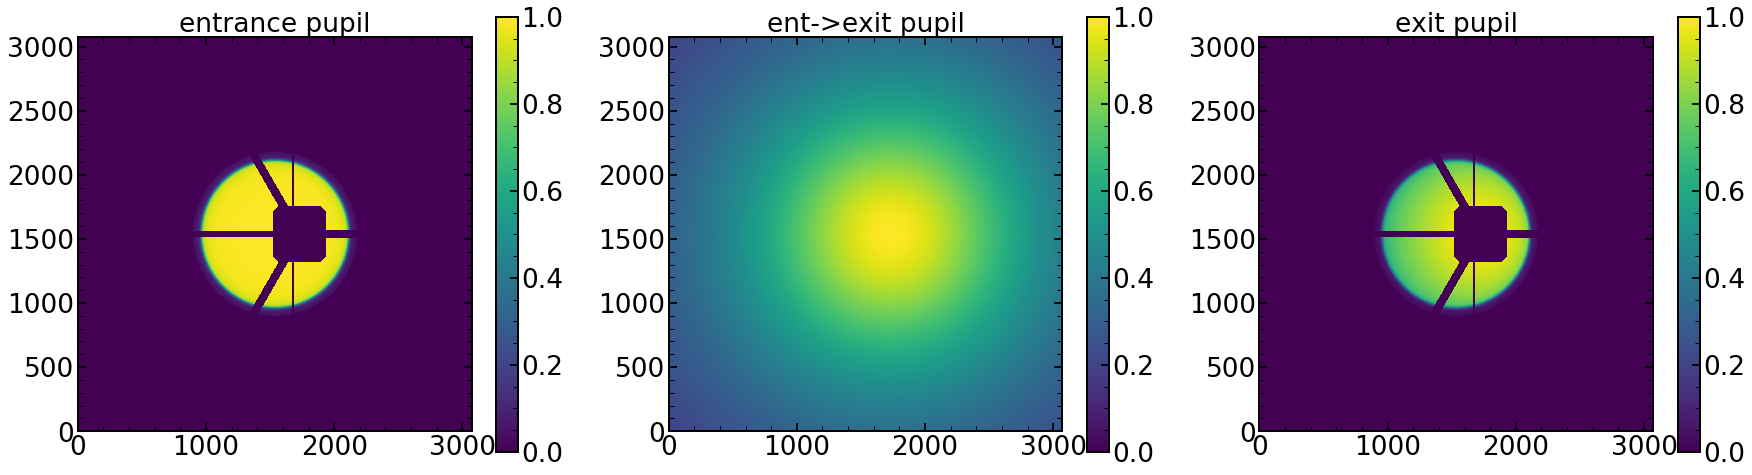

In [10]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

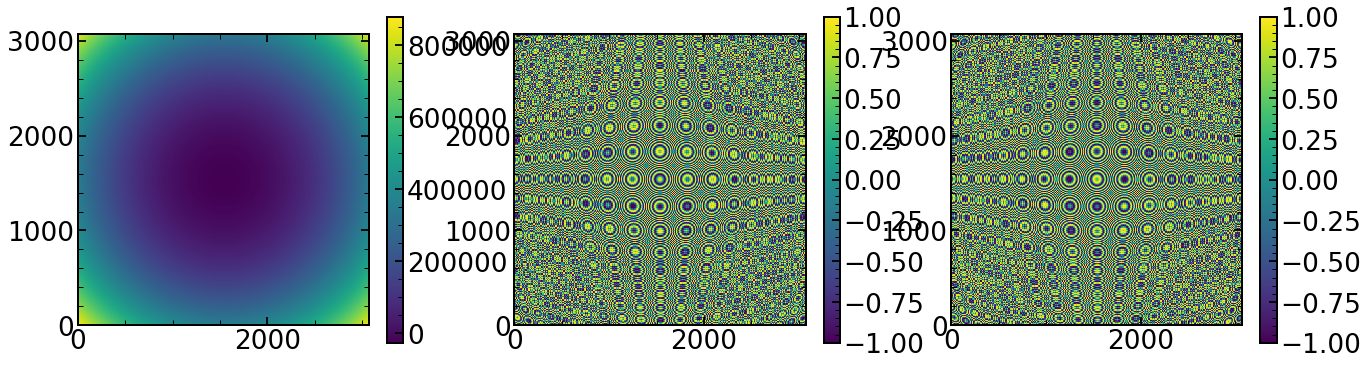

In [11]:
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()


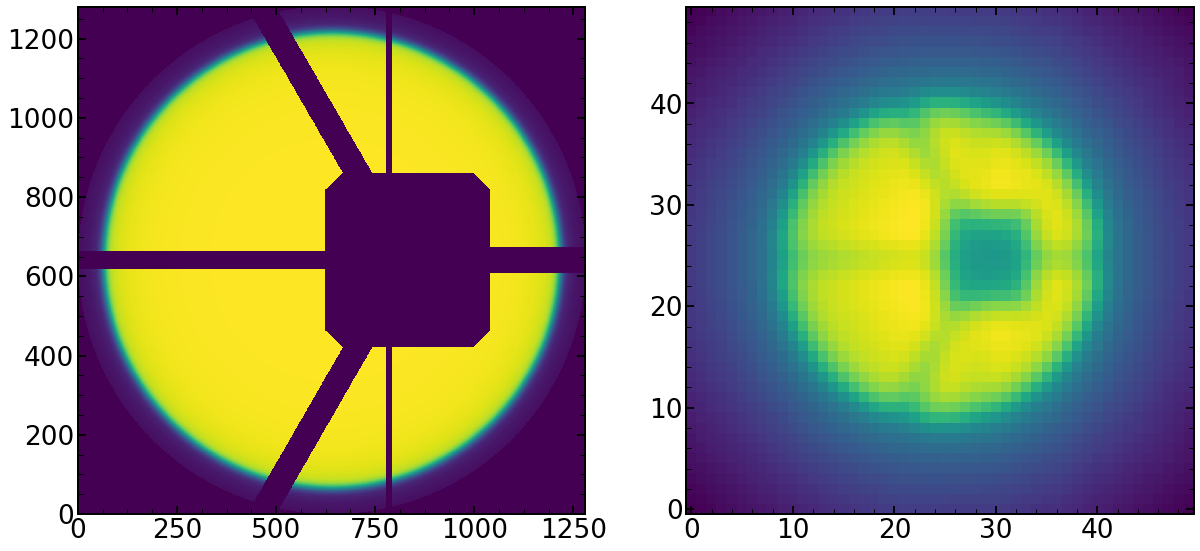

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

### unit test - z22

In [13]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
           'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.5,0,0,0,0,0,0,0,0,0,0.99,
                                 0.65,0.1,0.3,0.0,0.07,0.0,
                                 0.3,1.0,1,1,
                                 0.0,-0.0,0.90,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,zmax=22)  

res=model(allparameters_proposal)
print(res)

version of the code is: 0.19
zmax: 22
-4301.887998020042


In [14]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

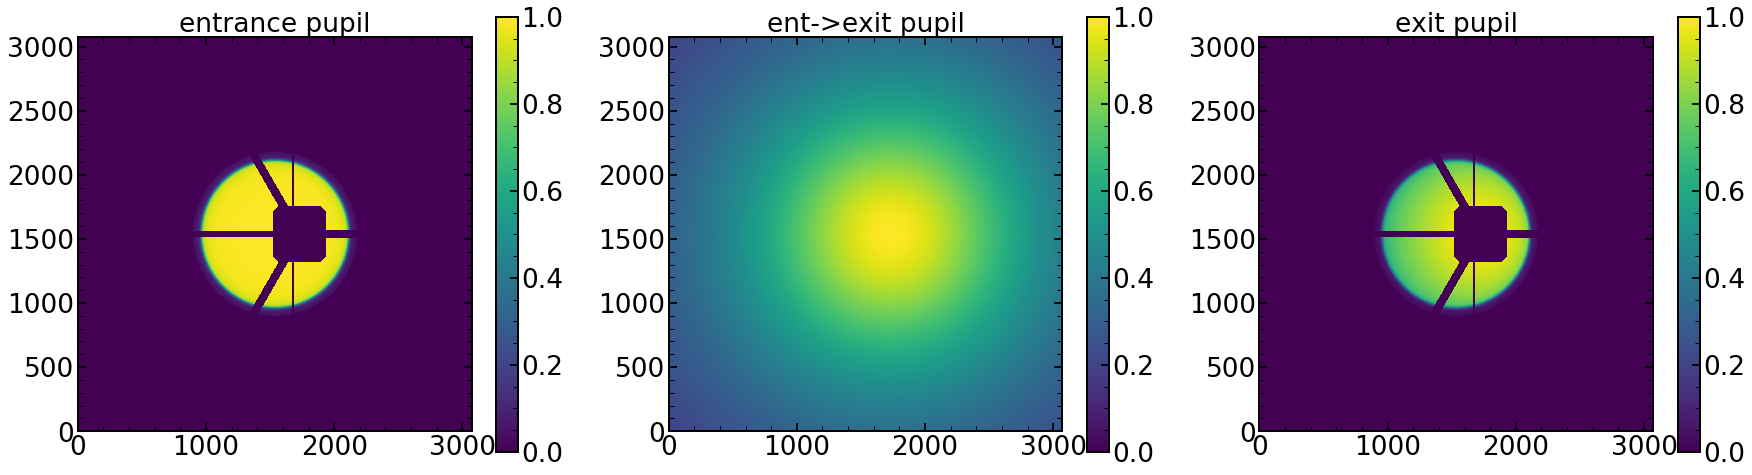

In [15]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

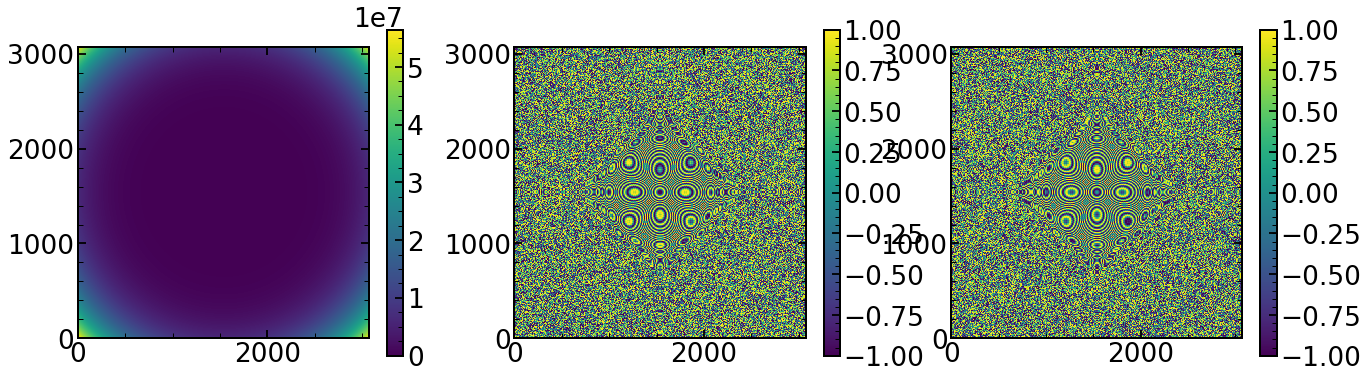

In [16]:
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()


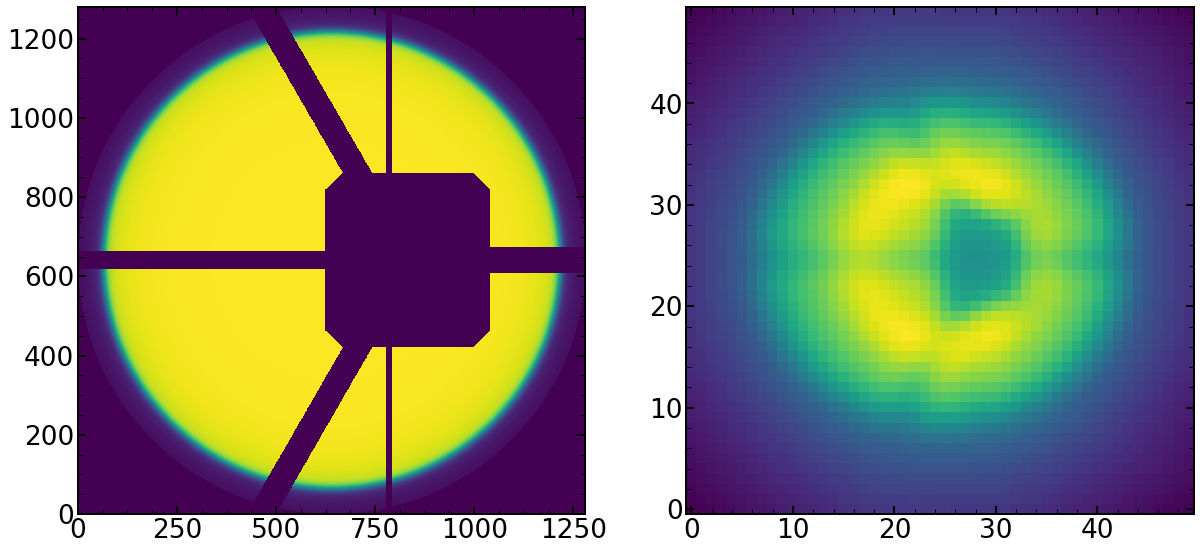

In [17]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

# Dec52

## script

In [238]:
import pickle

with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalNe_expanded.pkl', 'rb') as f:
    finalNe=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalHgAr_expanded.pkl', 'rb') as f:
    finalHgAr=pickle.load(f)

list_of_HgAr_to_analyze=finalHgAr.index[(finalHgAr['fiber'].values.astype(int)<=7)&(finalHgAr['fiber'].values.astype(int)>=2)
                                        &(finalHgAr['close'].values.astype(int)==1)&(finalHgAr['wavelength'].values.astype(float)<1000)&(finalHgAr['wavelength'].values.astype(float)>600)]
print(len(list_of_HgAr_to_analyze))
list_of_Ne_to_analyze=finalNe.index[(finalNe['fiber'].values.astype(float)<=7)&(finalNe['fiber'].values.astype(float)>=2)&(finalNe['close'].values.astype(float)==1)]
print(len(list_of_Ne_to_analyze))

48
24


In [23]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(52)+'S'+str(single_spot)+'Dec.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558,8600]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI52.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger52'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(52)+'S'+str(single_spot)+'Dec.sh \n')

file.close()

In [24]:
#MPI
for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(525)+'S'+str(single_spot)+'Dec.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in np.array([8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558,8600])+90:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI52.py "+str(obs)+" "+str(single_spot)+" 40 5 Ne\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger525'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(525)+'S'+str(single_spot)+'Dec.sh \n')

file.close()

## Codes

In [25]:
import pickle

with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalNe_expanded.pkl', 'rb') as f:
    finalNe=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalHgAr_expanded.pkl', 'rb') as f:
    finalHgAr=pickle.load(f)

list_of_HgAr_to_analyze=finalHgAr.index[(finalHgAr['fiber'].values.astype(int)<=7)&(finalHgAr['fiber'].values.astype(int)>=2)
                                        &(finalHgAr['close'].values.astype(int)==1)&(finalHgAr['wavelength'].values.astype(float)<900)&(finalHgAr['wavelength'].values.astype(float)>700)]
print(len(list_of_HgAr_to_analyze))
list_of_Ne_to_analyze=finalNe.index[(finalNe['fiber'].values.astype(float)<=7)&(finalNe['fiber'].values.astype(float)>=2)&(finalNe['close'].values.astype(float)==1)]
print(len(list_of_Ne_to_analyze))

30
24


In [26]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns_analysis=columns+['chi2','chi2max']

columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
           'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

In [27]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    columns=columns22
    for var_number in range(len(columns)):
        #print(var_number)
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            if step==0:
                step=10e-17
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except IndexError:
            if var_number!=25:
                print(columns[var_number]+': failed!')
                minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        #print(minchain_err_test)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)
    
    
import scipy.optimize as optimize
def curve_fit_custom_lin(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a,b=V
    yfit=lin_fit_1D(index_arr,a,b)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2

def curve_fit_custom_con(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a=V
    yfit=lin_fit_1DConstant(index_arr,a)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2 

In [28]:
def create_results_of_fit_single(date,single_number,arc=None,zMax=None):
    """create solution from a single image, create error and lower and upper erros

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
    @returns       results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper to be fed to solution_at_0_and_plots
    """
    print(zMax)
    if arc is None:
        arc='HgAr'
        
    if arc=='HgAr':
        obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
    elif arc=='Ne':
        obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90
        
    if zMax==22:
        columns_analysis=columns22_analysis
    
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=obs_possibilites

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
            else:       
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
                #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

 
            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(minchain_err_old)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            #print(results_of_fit_single.iloc[single_defocus])
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' '+str(arc)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper


def create_results_of_fit_single_focus(date,single_number,arc=None,zMax=None):
    """create solution from a single image, create error and lower and upper erros

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
    @returns       results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper to be fed to solution_at_0_and_plots
    """
    print(zMax)
    if arc is None:
        arc='HgAr'
        
    if arc=='HgAr':
        obs_possibilites=np.array([8576,8579,8582,8585,8588,8591,8594,8597])
    elif arc=='Ne':
        obs_possibilites=np.array([8576,8579,8582,8585,8588,8591,8594,8597])+90
        
    if zMax==22:
        columns_analysis=columns22_analysis
        
    labels=['8576','8579','8582','8585','8588','8591','8594','8597']
    results_of_fit_single=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=obs_possibilites

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
            else:       
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
                #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

 
            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(minchain_err_old)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            #print(results_of_fit_single.iloc[single_defocus])
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' '+str(arc)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [29]:
def solution_at_0_and_plots(date,single_number,arc,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=True,zMax=None):
    """create solution at the focus and plot dependence with defocu

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
  
    """    
    
    if zMax==22:
        columns_analysis=columns22_analysis
        columns=columns22
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=5:
        if zMax==22:
            solution_at_0=np.full(31+11,0)
        else:
            solution_at_0=np.full(31,0)       
        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:

            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr)
            #print(z4_arr_err)
            #print(z4_arr_err_up)
            #print(z4_arr_err_low)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]
            #print(q)
            #print(index_arr_no0)
            #print(z4_arr_no0)
            #print(z4_arr_no0_err)
            #print(z4_arr_no0_err_up)
            #print(z4_arr_no0_err_low)
            
            
            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            interim_zero_solutions=[]
            if q in columns[:8+11]:
                # these variables are fit via linear fit, without values at focus
                # it is z4-z11
                # for loop below removes 2 points from the fit that create largest deviations from median result in focus
                for l in range(len(index_arr_no0)):
                    #print('good_index'+str(np.delete(index_arr_no0,l)))
                    #print('index_arr_no0'+str(np.delete(z4_arr_no0,l)))
                    #print('z4_arr_no0_err_low'+str(np.delete(z4_arr_no0_err_low,l)))
                    #print('z4_arr_no0_err_up'+str(np.delete(z4_arr_no0_err_up,l)))
                    popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,lin_fit_1D(0,popt[0],popt[1])])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                #print('good_index'+str(good_index))
                #print('index_arr_no0'+str(index_arr_no0))
                #print('z4_arr_no0_err_low'+str(z4_arr_no0_err_low))
                #print('z4_arr_no0_err_up'+str(z4_arr_no0_err_up))
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                #print(popt)
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            interim_zero_solutions=[]
            if q in columns[8+11:25+11]:
                # these variables are set at mean value (constant fit), without values at focus
                # these are variables that describe the pupil
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,popt[0]])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                third_max_dif=np.sort(interim_zero_solutions_arr_dif)[-3]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<=(third_max_dif*1.1)]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[25+11:]),np.array(['chi2','chi2max'])),axis=0):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######
            #print(q)
            #print(fit_res)
            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            #print('prediction for focus: '+str(q)+' '+str(fit_res[9]))
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(arc)+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(arc)+str(single_number))

            plt.close()   
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

## Look at the results at one point  - defocused analysis


In [195]:
date='Dec52'
obs=str(8555)
single_number='66'
image_index=int(single_number)
eps=5
arc='HgAr'


STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/"

if arc=="HgAr":
    single_number_focus=8603
elif arc=="Ne":
    single_number_focus=8693    
else:
    print("Not recognized arc-line")

if arc=='HgAr':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
elif arc=='Ne':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if arc=="HgAr":
    finalArc=finalHgAr
elif arc=="Ne":
    finalArc=finalNe    
else:
    print("Not recognized arc-line")    
        
finalArc.loc[int(single_number)]

fiber                     5
xc                     2088
yc                     1950
wavelength         795.0522
close                     1
lamp                   HgAr
xc_effective           2157
old_index                55
old_index_aprox          55
Name: 66, dtype: object

In [196]:
list_of_masks=create_mask(sci_image_focus_large)
diagonal_cross=list_of_masks[3]
res_diagonal_cross_large=create_res_data(sci_image_focus_large,diagonal_cross,custom_cent=True,size_pixel=15)
distances_large=range(len(res_diagonal_cross_large))
last_distance=np.array(distances_large[101:])[np.log10(res_diagonal_cross_large[101:])>0.5][-1]
# if the average is below 0 terminate at that position

where_are_NaNs=np.isnan(np.log10(np.array(res_diagonal_cross_large[101:])))
if np.sum(where_are_NaNs)>0:
    first_NaN_position=np.array(distances_large[101:])[where_are_NaNs][0]
else:
    first_NaN_position=last_distance
last_distance=np.min([first_NaN_position,last_distance]) -1

z=np.polyfit(np.log10(np.array(distances_large[101:last_distance])),np.log10(np.array(res_diagonal_cross_large)[101:last_distance]),1)
deduced_scattering_slope=z[0]-0.05
print("deduced_scattering_slope: "+str(deduced_scattering_slope))

deduced_scattering_slope: -2.0909030783842426


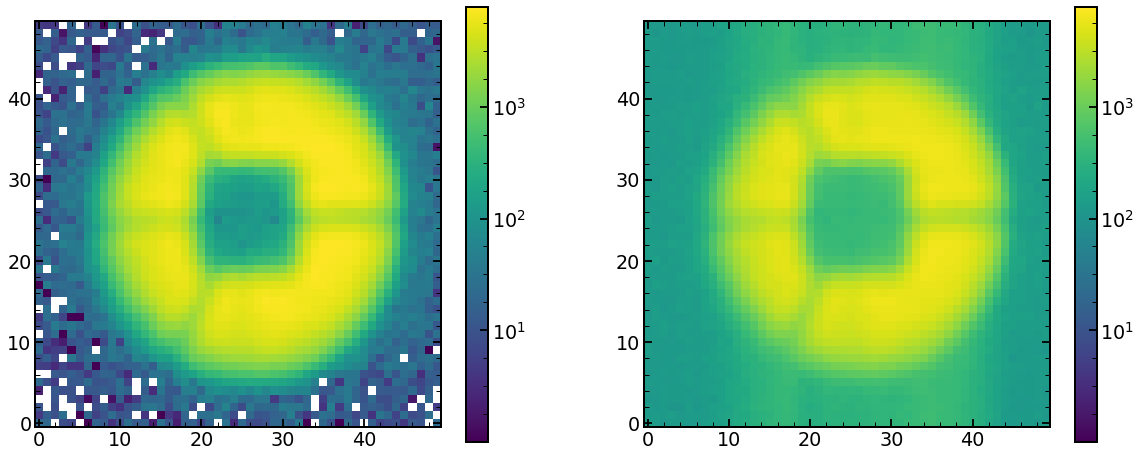

In [197]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


In [198]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 4908.480459672633
minimal chi2 reduced is: 3.9199812391225057


In [199]:
if len(minchain)==42:
    columns=columns22
    dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
    print(dfz22)
    dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

    dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
    print(dfglobal1)

    dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
    print(dfglobal2)


          z4        z5        z6        z7        z8       z9       z10  \
0  25.467246  0.272947 -0.821197 -0.164216 -0.100498  0.10709 -0.209965   

        z11  
0 -0.375892  
       z12       z13       z14       z15       z16       z17      z18  \
0 -0.00905  0.058564 -0.016388  0.009061  0.042929 -0.014657 -0.01251   

        z19       z20       z21  
0 -0.004144 -0.010891 -0.022891  
        z22   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0 -0.005773  0.684351   0.072039  0.010149  0.016405  0.058139    -0.009571   

   radiometricEffect  radiometricExponent    x_ilum    ...     frd_sigma  \
0           0.212291             0.458898  0.906501    ...      0.081934   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.645091  1.020566           -0.021063  109104.124039   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.304045              0.002139      0.397035  1.884141  0.997407

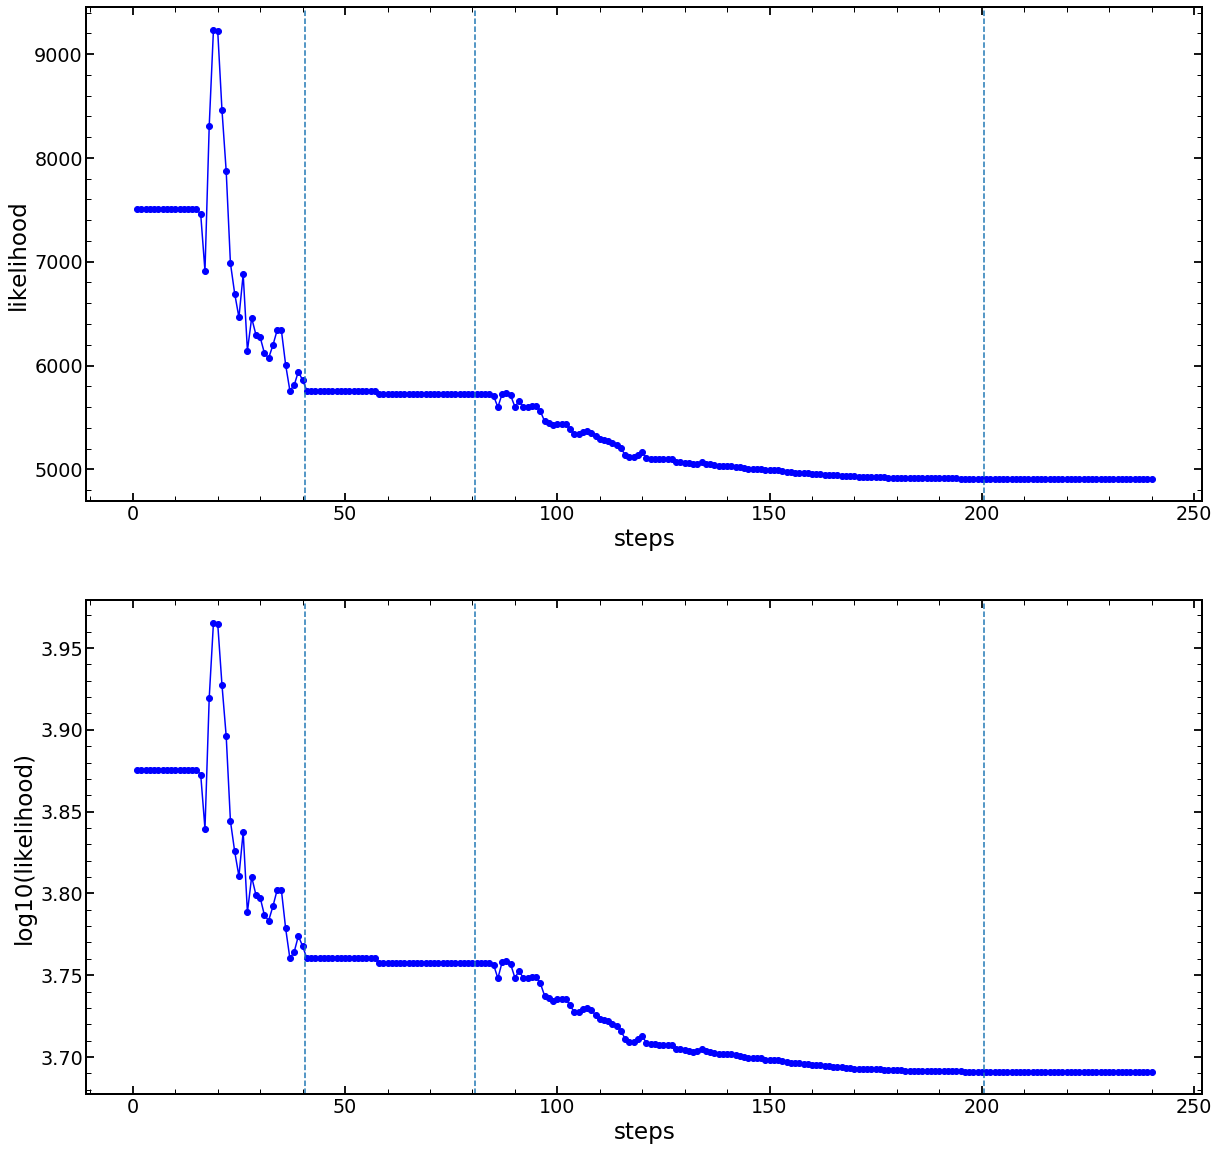

In [200]:
size=40

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [201]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain)

zmax: 22


-4908.997846543913

In [202]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')


optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

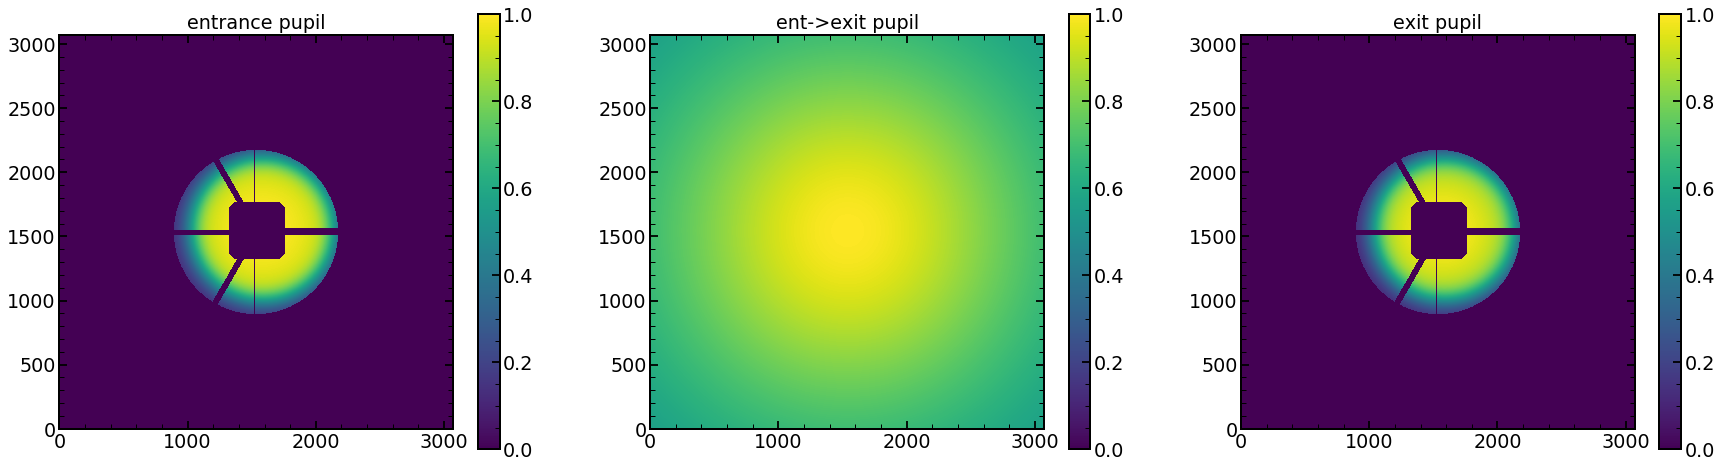

In [203]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

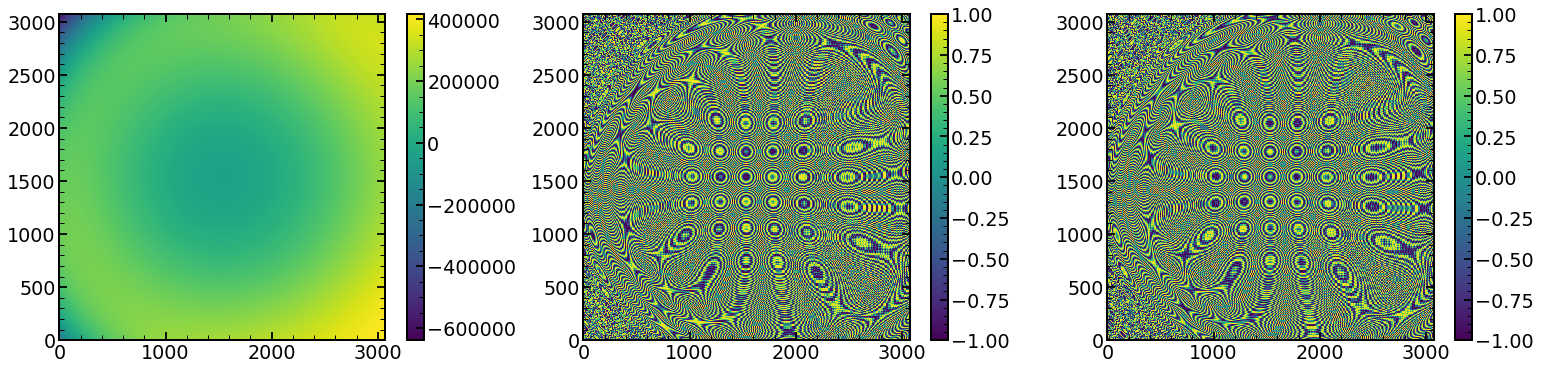

In [204]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

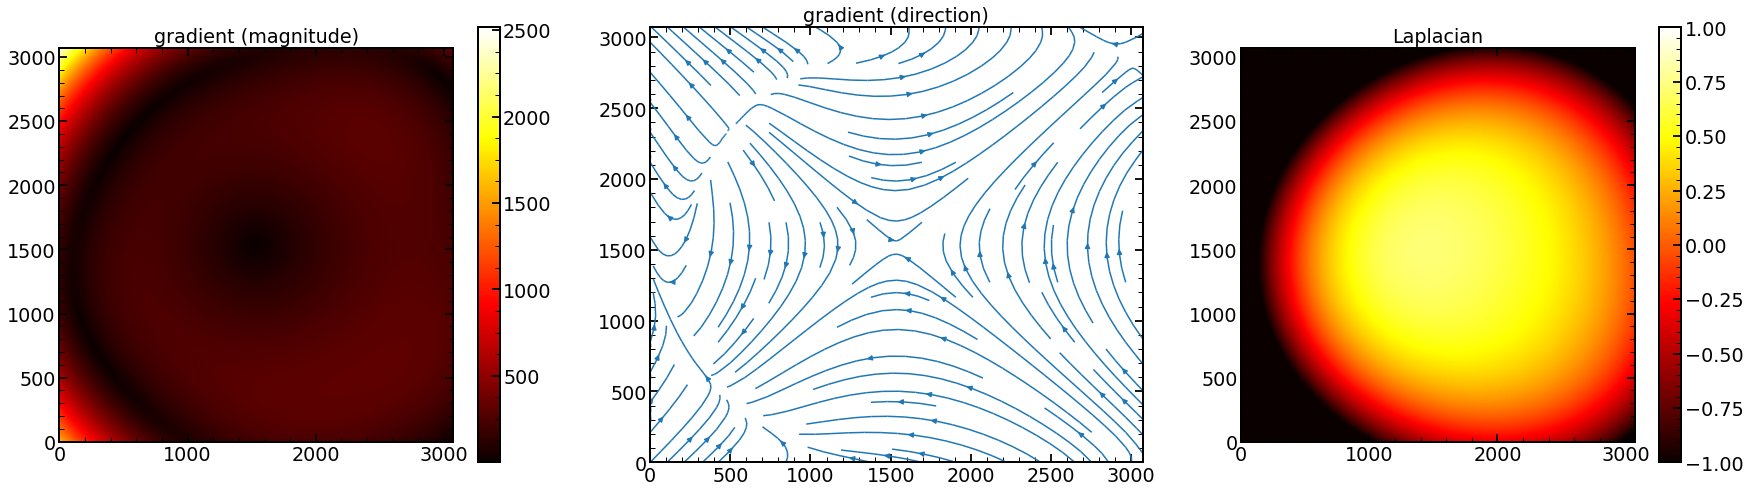

In [205]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

chi**2 reduced is: 3.9203951672643704
Abs of residual divided by total flux is: 0.038134885162134834
Abs of residual divided by largest value of a flux in the image is: 0.09857671254065029


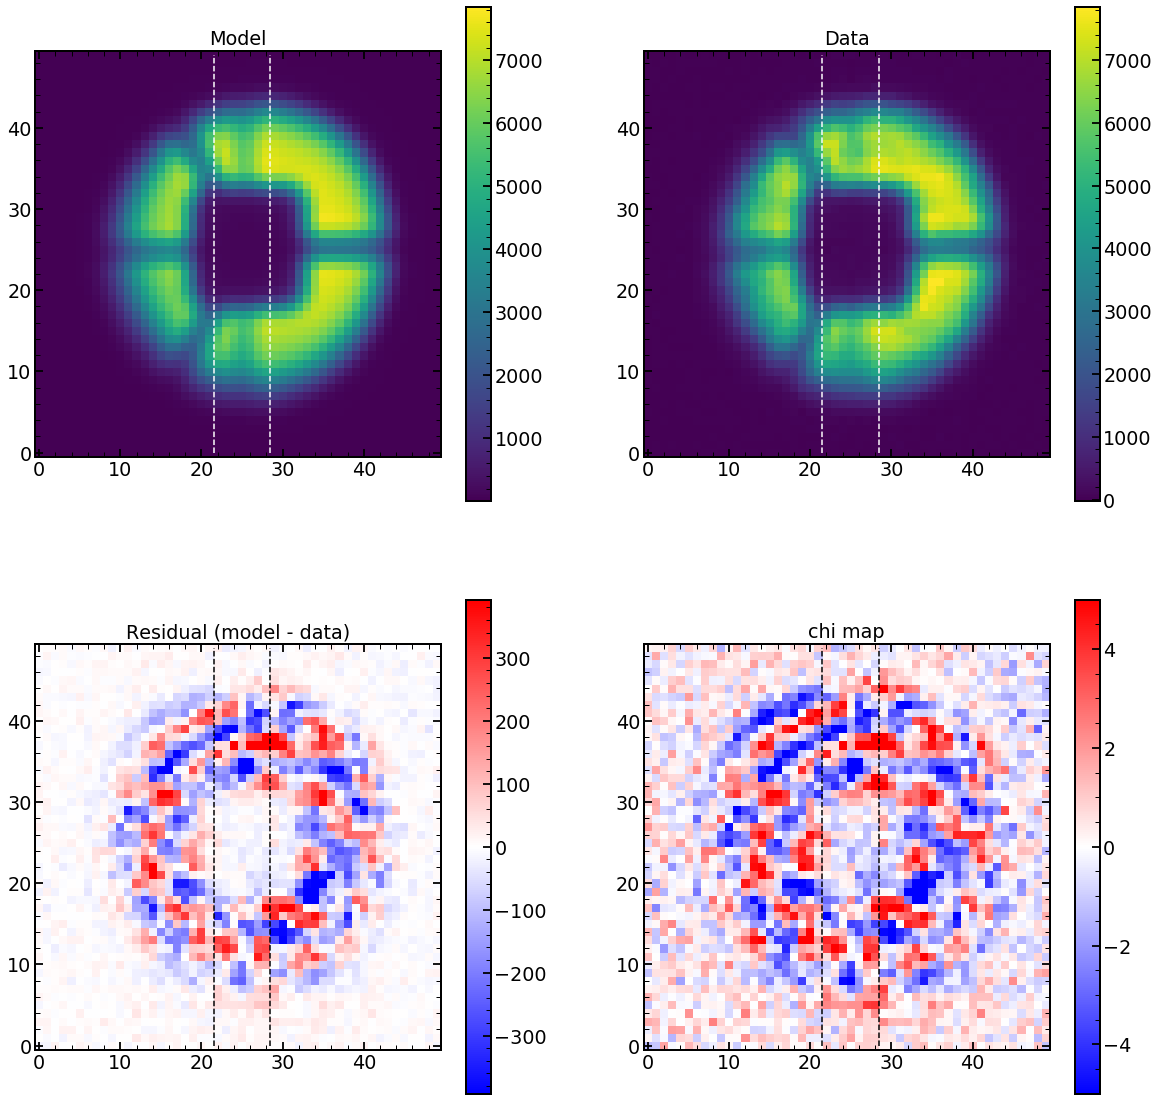

In [206]:
single_analysis.create_basic_comparison_plot()

3.9203951672643704
chi**2 reduced is: 3.9203951672643704
Abs of residual divided by total flux is: 0.038134885162134834
Abs of residual divided by largest value of a flux in the image is: 0.09857671254065029


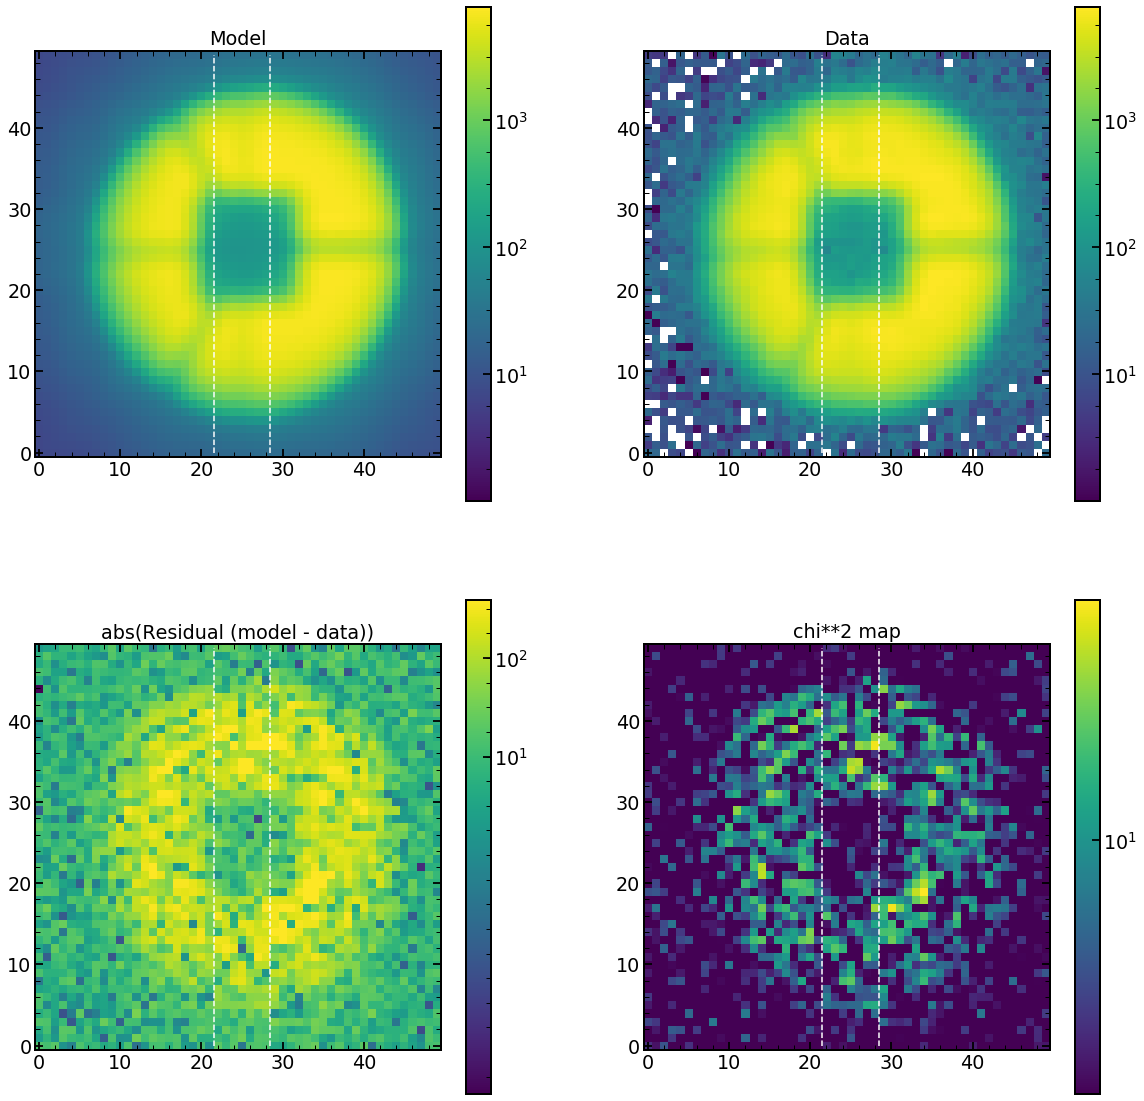

In [207]:
single_analysis.create_basic_comparison_plot_log()

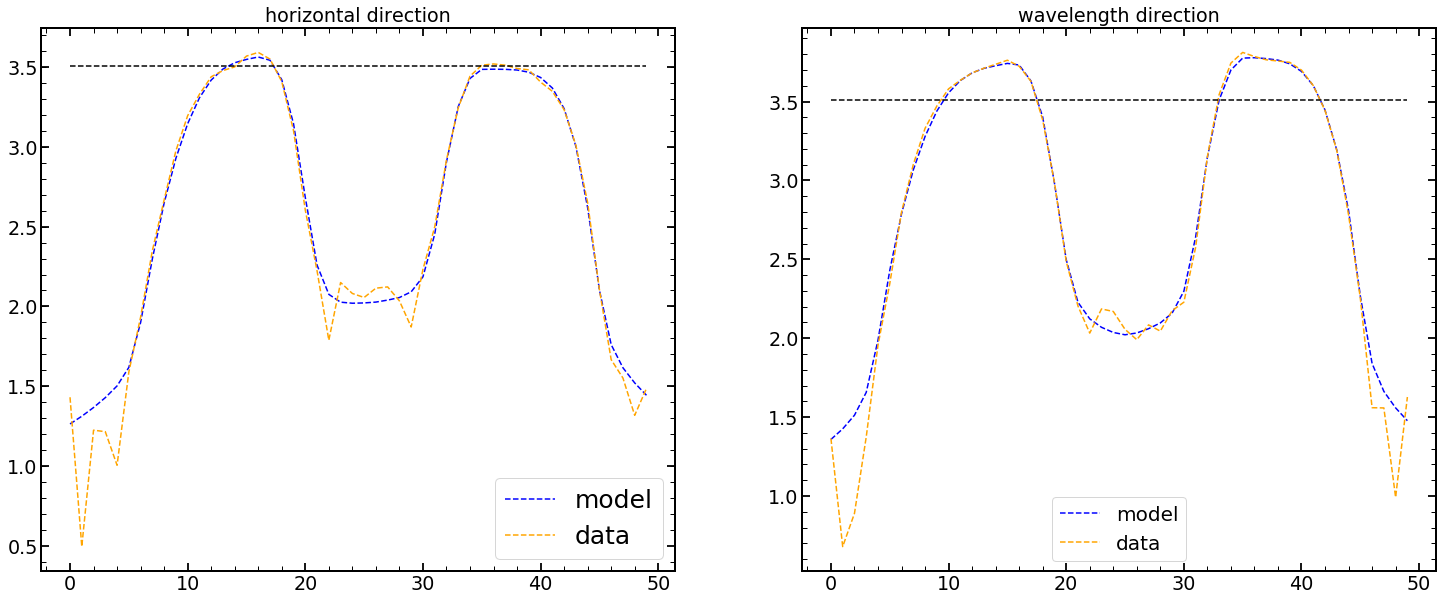

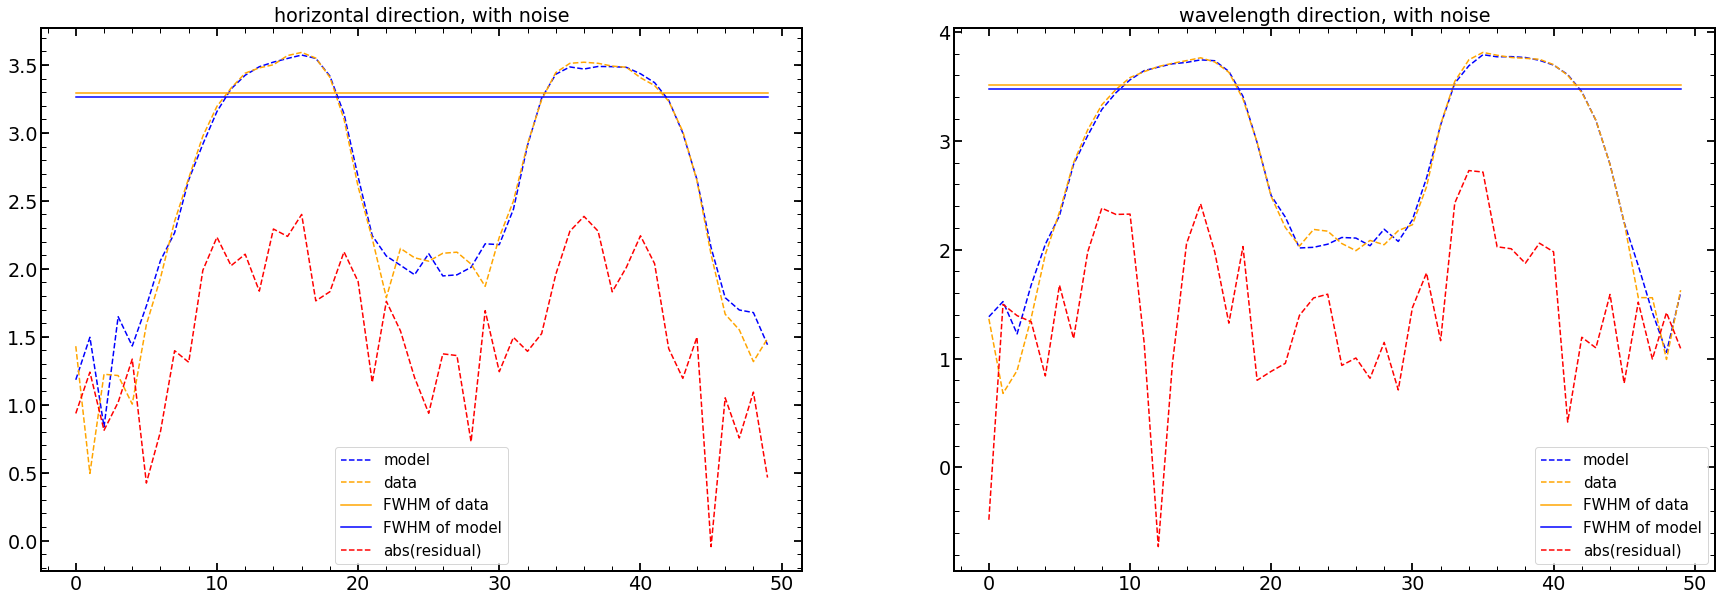

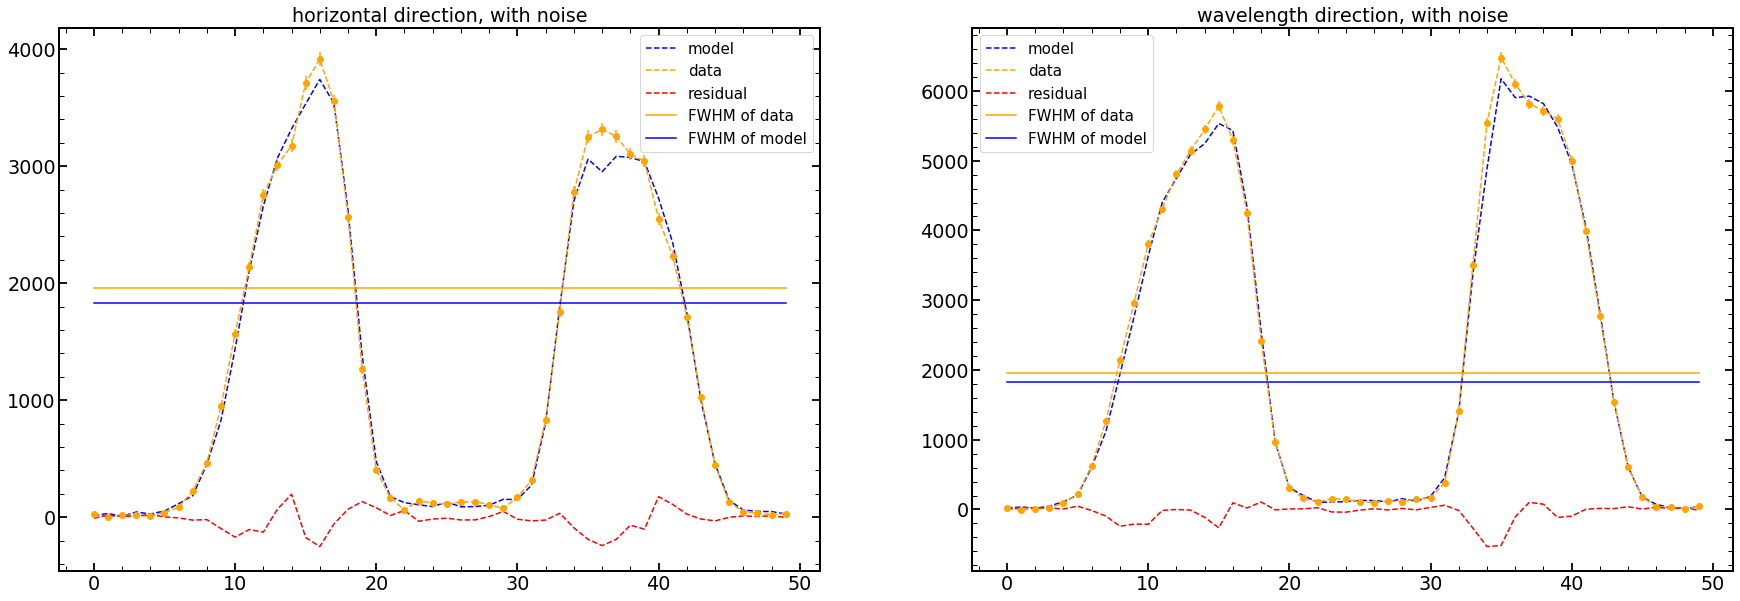

In [208]:
single_analysis.create_cut_plots()

# Core analysis 

## Defocus plots 

In [211]:
for i in tqdm(range(len(finalHgAr))):
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Dec52',i,'HgAr',22)
    solution_at_0=solution_at_0_and_plots('Dec52',i,'HgAr',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,'True',22)

 11%|█         | 13/120 [00:00<00:00, 126.36it/s]

22
0 8552 HgAr is NOT found or failed!
0 8555 HgAr is NOT found or failed!
0 8558 HgAr is NOT found or failed!
0 8561 HgAr is NOT found or failed!
0 8564 HgAr is NOT found or failed!
0 8567 HgAr is NOT found or failed!
0 8570 HgAr is NOT found or failed!
0 8573 HgAr is NOT found or failed!
0 8603 HgAr is NOT found or failed!
0 8600 HgAr is NOT found or failed!
0 8606 HgAr is NOT found or failed!
0 8609 HgAr is NOT found or failed!
0 8612 HgAr is NOT found or failed!
0 8615 HgAr is NOT found or failed!
0 8618 HgAr is NOT found or failed!
0 8621 HgAr is NOT found or failed!
0 8624 HgAr is NOT found or failed!
0 8627 HgAr is NOT found or failed!
22
1 8552 HgAr is NOT found or failed!
1 8555 HgAr is NOT found or failed!
1 8558 HgAr is NOT found or failed!
1 8561 HgAr is NOT found or failed!
1 8564 HgAr is NOT found or failed!
1 8567 HgAr is NOT found or failed!
1 8570 HgAr is NOT found or failed!
1 8573 HgAr is NOT found or failed!
1 8603 HgAr is NOT found or failed!
1 8600 HgAr is NOT fou

25 obs (Emcee3): 8555 is found!
25 8558 HgAr is NOT found or failed!
25 8561 HgAr is NOT found or failed!
25 8564 HgAr is NOT found or failed!
25 obs (Emcee3): 8567 is found!
25 8570 HgAr is NOT found or failed!
25 obs (Emcee3): 8573 is found!
25 obs (Emcee3): 8603 is found!
25 8600 HgAr is NOT found or failed!
25 obs (Emcee3): 8606 is found!
25 8609 HgAr is NOT found or failed!
25 obs (Emcee3): 8612 is found!
25 8615 HgAr is NOT found or failed!
25 8618 HgAr is NOT found or failed!
25obs (Emcee2): 8621 is found!
25 obs (Emcee3): 8624 is found!
25 obs (Emcee3): 8627 is found!


 22%|██▏       | 26/120 [00:23<01:25,  1.10it/s] 

22
26 8552 HgAr is NOT found or failed!
26 8555 HgAr is NOT found or failed!
26 8558 HgAr is NOT found or failed!
26 8561 HgAr is NOT found or failed!
26 8564 HgAr is NOT found or failed!
26 8567 HgAr is NOT found or failed!
26 8570 HgAr is NOT found or failed!
26 8573 HgAr is NOT found or failed!
26 8603 HgAr is NOT found or failed!
26 8600 HgAr is NOT found or failed!
26 8606 HgAr is NOT found or failed!
26 8609 HgAr is NOT found or failed!
26 8612 HgAr is NOT found or failed!
26 8615 HgAr is NOT found or failed!
26 8618 HgAr is NOT found or failed!
26 8621 HgAr is NOT found or failed!
26 8624 HgAr is NOT found or failed!
26 8627 HgAr is NOT found or failed!
22
27 obs (Emcee3): 8552 is found!
27 obs (Emcee3): 8555 is found!
27 8558 HgAr is NOT found or failed!
27 8561 HgAr is NOT found or failed!
27 8564 HgAr is NOT found or failed!
27 obs (Emcee3): 8567 is found!
27 8570 HgAr is NOT found or failed!
27 obs (Emcee3): 8573 is found!
27 obs (Emcee3): 8603 is found!
27 8600 HgAr is NOT 

 23%|██▎       | 28/120 [00:47<02:37,  1.71s/it]

22
28 8552 HgAr is NOT found or failed!
28 8555 HgAr is NOT found or failed!
28 8558 HgAr is NOT found or failed!
28 8561 HgAr is NOT found or failed!
28 8564 HgAr is NOT found or failed!
28 8567 HgAr is NOT found or failed!
28 8570 HgAr is NOT found or failed!
28 8573 HgAr is NOT found or failed!
28 8603 HgAr is NOT found or failed!
28 8600 HgAr is NOT found or failed!
28 8606 HgAr is NOT found or failed!
28 8609 HgAr is NOT found or failed!
28 8612 HgAr is NOT found or failed!
28 8615 HgAr is NOT found or failed!
28 8618 HgAr is NOT found or failed!
28 8621 HgAr is NOT found or failed!
28 8624 HgAr is NOT found or failed!
28 8627 HgAr is NOT found or failed!
22
29 obs (Emcee3): 8552 is found!
29 obs (Emcee3): 8555 is found!
29 8558 HgAr is NOT found or failed!
29 8561 HgAr is NOT found or failed!
29 8564 HgAr is NOT found or failed!
29 obs (Emcee3): 8567 is found!
29 8570 HgAr is NOT found or failed!
29 obs (Emcee3): 8573 is found!
29 obs (Emcee3): 8603 is found!
29 8600 HgAr is NOT 

 25%|██▌       | 30/120 [01:13<03:39,  2.44s/it]

22
30 obs (Emcee3): 8552 is found!
30 obs (Emcee3): 8555 is found!
30 8558 HgAr is NOT found or failed!
30 8561 HgAr is NOT found or failed!
30 8564 HgAr is NOT found or failed!
30 obs (Emcee3): 8567 is found!
30 8570 HgAr is NOT found or failed!
30 obs (Emcee3): 8573 is found!
30 obs (Emcee3): 8603 is found!
30 8600 HgAr is NOT found or failed!
30 obs (Emcee3): 8606 is found!
30 8609 HgAr is NOT found or failed!
30 obs (Emcee3): 8612 is found!
30 8615 HgAr is NOT found or failed!
30 8618 HgAr is NOT found or failed!
30 8621 HgAr is NOT found or failed!
30 obs (Emcee3): 8624 is found!
30 obs (Emcee3): 8627 is found!


 26%|██▌       | 31/120 [01:36<04:38,  3.13s/it]

22
31 obs (Emcee3): 8552 is found!
31 obs (Emcee3): 8555 is found!
31 8558 HgAr is NOT found or failed!
31 8561 HgAr is NOT found or failed!
31 8564 HgAr is NOT found or failed!
31 obs (Emcee3): 8567 is found!
31 8570 HgAr is NOT found or failed!
31 obs (Emcee3): 8573 is found!
31 obs (Emcee3): 8603 is found!
31 8600 HgAr is NOT found or failed!
31 obs (Emcee3): 8606 is found!
31 8609 HgAr is NOT found or failed!
31 obs (Emcee3): 8612 is found!
31 8615 HgAr is NOT found or failed!
31 8618 HgAr is NOT found or failed!
31obs (Emcee2): 8621 is found!
31 obs (Emcee3): 8624 is found!
31 obs (Emcee3): 8627 is found!


 27%|██▋       | 32/120 [02:01<05:34,  3.80s/it]

22
32 obs (Emcee3): 8552 is found!
32 obs (Emcee3): 8555 is found!
32 8558 HgAr is NOT found or failed!
32 8561 HgAr is NOT found or failed!
32 8564 HgAr is NOT found or failed!
32 obs (Emcee3): 8567 is found!
32 8570 HgAr is NOT found or failed!
32 obs (Emcee3): 8573 is found!
32 obs (Emcee3): 8603 is found!
32 8600 HgAr is NOT found or failed!
32 obs (Emcee3): 8606 is found!
32 8609 HgAr is NOT found or failed!
32 obs (Emcee3): 8612 is found!
32 8615 HgAr is NOT found or failed!
32 8618 HgAr is NOT found or failed!
32obs (Emcee2): 8621 is found!
32 obs (Emcee3): 8624 is found!
32 obs (Emcee3): 8627 is found!


 28%|██▊       | 33/120 [02:25<06:23,  4.41s/it]

22
33 obs (Emcee3): 8552 is found!
33 obs (Emcee3): 8555 is found!
33 8558 HgAr is NOT found or failed!
33 8561 HgAr is NOT found or failed!
33 8564 HgAr is NOT found or failed!
33 obs (Emcee3): 8567 is found!
33 8570 HgAr is NOT found or failed!
33 obs (Emcee3): 8573 is found!
33 obs (Emcee3): 8603 is found!
33 8600 HgAr is NOT found or failed!
33 obs (Emcee3): 8606 is found!
33 8609 HgAr is NOT found or failed!
33 obs (Emcee3): 8612 is found!
33 8615 HgAr is NOT found or failed!
33 8618 HgAr is NOT found or failed!
33 8621 HgAr is NOT found or failed!
33 obs (Emcee3): 8624 is found!
33 obs (Emcee3): 8627 is found!


 28%|██▊       | 34/120 [02:48<07:06,  4.95s/it]

22
34 8552 HgAr is NOT found or failed!
34 8555 HgAr is NOT found or failed!
34 8558 HgAr is NOT found or failed!
34 8561 HgAr is NOT found or failed!
34 8564 HgAr is NOT found or failed!
34 8567 HgAr is NOT found or failed!
34 8570 HgAr is NOT found or failed!
34 8573 HgAr is NOT found or failed!
34 8603 HgAr is NOT found or failed!
34 8600 HgAr is NOT found or failed!
34 8606 HgAr is NOT found or failed!
34 8609 HgAr is NOT found or failed!
34 8612 HgAr is NOT found or failed!
34 8615 HgAr is NOT found or failed!
34 8618 HgAr is NOT found or failed!
34 8621 HgAr is NOT found or failed!
34 8624 HgAr is NOT found or failed!
34 8627 HgAr is NOT found or failed!
22
35 obs (Emcee3): 8552 is found!
35 obs (Emcee3): 8555 is found!
35 8558 HgAr is NOT found or failed!
35 8561 HgAr is NOT found or failed!
35 8564 HgAr is NOT found or failed!
35 obs (Emcee3): 8567 is found!
35 8570 HgAr is NOT found or failed!
35 obs (Emcee3): 8573 is found!
35 obs (Emcee3): 8603 is found!
35 8600 HgAr is NOT 

 30%|███       | 36/120 [03:11<07:27,  5.32s/it]

22
36 8552 HgAr is NOT found or failed!
36 8555 HgAr is NOT found or failed!
36 8558 HgAr is NOT found or failed!
36 8561 HgAr is NOT found or failed!
36 8564 HgAr is NOT found or failed!
36 8567 HgAr is NOT found or failed!
36 8570 HgAr is NOT found or failed!
36 8573 HgAr is NOT found or failed!
36 8603 HgAr is NOT found or failed!
36 8600 HgAr is NOT found or failed!
36 8606 HgAr is NOT found or failed!
36 8609 HgAr is NOT found or failed!
36 8612 HgAr is NOT found or failed!
36 8615 HgAr is NOT found or failed!
36 8618 HgAr is NOT found or failed!
36 8621 HgAr is NOT found or failed!
36 8624 HgAr is NOT found or failed!
36 8627 HgAr is NOT found or failed!
22
37 obs (Emcee3): 8552 is found!
37 obs (Emcee3): 8555 is found!
37 obs (Emcee3): 8558 is found!
37 8561 HgAr is NOT found or failed!
37 8564 HgAr is NOT found or failed!
37 obs (Emcee3): 8567 is found!
37 8570 HgAr is NOT found or failed!
37 obs (Emcee3): 8573 is found!
37 obs (Emcee3): 8603 is found!
37 obs (Emcee3): 8600 is 

 32%|███▏      | 38/120 [03:35<07:44,  5.66s/it]

22
38 8552 HgAr is NOT found or failed!
38 8555 HgAr is NOT found or failed!
38 8558 HgAr is NOT found or failed!
38 8561 HgAr is NOT found or failed!
38 8564 HgAr is NOT found or failed!
38 8567 HgAr is NOT found or failed!
38 8570 HgAr is NOT found or failed!
38 8573 HgAr is NOT found or failed!
38 8603 HgAr is NOT found or failed!
38 8600 HgAr is NOT found or failed!
38 8606 HgAr is NOT found or failed!
38 8609 HgAr is NOT found or failed!
38 8612 HgAr is NOT found or failed!
38 8615 HgAr is NOT found or failed!
38 8618 HgAr is NOT found or failed!
38 8621 HgAr is NOT found or failed!
38 8624 HgAr is NOT found or failed!
38 8627 HgAr is NOT found or failed!
22
39 obs (Emcee3): 8552 is found!
39 obs (Emcee3): 8555 is found!
39 8558 HgAr is NOT found or failed!
39 8561 HgAr is NOT found or failed!
39 8564 HgAr is NOT found or failed!
39 obs (Emcee3): 8567 is found!
39 8570 HgAr is NOT found or failed!
39 obs (Emcee3): 8573 is found!
39 obs (Emcee3): 8603 is found!
39 8600 HgAr is NOT 

 33%|███▎      | 40/120 [03:59<07:58,  5.98s/it]

22
40 8552 HgAr is NOT found or failed!
40 8555 HgAr is NOT found or failed!
40 8558 HgAr is NOT found or failed!
40 8561 HgAr is NOT found or failed!
40 8564 HgAr is NOT found or failed!
40 8567 HgAr is NOT found or failed!
40 8570 HgAr is NOT found or failed!
40 8573 HgAr is NOT found or failed!
40 8603 HgAr is NOT found or failed!
40 8600 HgAr is NOT found or failed!
40 8606 HgAr is NOT found or failed!
40 8609 HgAr is NOT found or failed!
40 8612 HgAr is NOT found or failed!
40 8615 HgAr is NOT found or failed!
40 8618 HgAr is NOT found or failed!
40 8621 HgAr is NOT found or failed!
40 8624 HgAr is NOT found or failed!
40 8627 HgAr is NOT found or failed!
22
41 obs (Emcee3): 8552 is found!
41 obs (Emcee3): 8555 is found!
41 8558 HgAr is NOT found or failed!
41 8561 HgAr is NOT found or failed!
41 8564 HgAr is NOT found or failed!
41 obs (Emcee3): 8567 is found!
41 8570 HgAr is NOT found or failed!
41 obs (Emcee3): 8573 is found!
41 obs (Emcee3): 8603 is found!
41 8600 HgAr is NOT 

 35%|███▌      | 42/120 [04:26<08:14,  6.35s/it]

22
42 obs (Emcee3): 8552 is found!
42 obs (Emcee3): 8555 is found!
42 8558 HgAr is NOT found or failed!
42 8561 HgAr is NOT found or failed!
42 8564 HgAr is NOT found or failed!
42 obs (Emcee3): 8567 is found!
42 8570 HgAr is NOT found or failed!
42 obs (Emcee3): 8573 is found!
42 obs (Emcee3): 8603 is found!
42 8600 HgAr is NOT found or failed!
42 obs (Emcee3): 8606 is found!
42 8609 HgAr is NOT found or failed!
42 obs (Emcee3): 8612 is found!
42 8615 HgAr is NOT found or failed!
42 8618 HgAr is NOT found or failed!
42obs (Emcee2): 8621 is found!
42 obs (Emcee3): 8624 is found!
42 obs (Emcee3): 8627 is found!


 36%|███▌      | 43/120 [04:52<08:43,  6.79s/it]

22
43 obs (Emcee3): 8552 is found!
43 obs (Emcee3): 8555 is found!
43 8558 HgAr is NOT found or failed!
43 8561 HgAr is NOT found or failed!
43 8564 HgAr is NOT found or failed!
43 obs (Emcee3): 8567 is found!
43 8570 HgAr is NOT found or failed!
43 obs (Emcee3): 8573 is found!
43 obs (Emcee3): 8603 is found!
43 8600 HgAr is NOT found or failed!
43 obs (Emcee3): 8606 is found!
43 8609 HgAr is NOT found or failed!
43 obs (Emcee3): 8612 is found!
43 8615 HgAr is NOT found or failed!
43 8618 HgAr is NOT found or failed!
43obs (Emcee2): 8621 is found!
43 obs (Emcee3): 8624 is found!
43 obs (Emcee3): 8627 is found!


 37%|███▋      | 44/120 [05:17<09:08,  7.21s/it]

22
44 obs (Emcee3): 8552 is found!
44 obs (Emcee3): 8555 is found!
44 8558 HgAr is NOT found or failed!
44 8561 HgAr is NOT found or failed!
44 8564 HgAr is NOT found or failed!
44 obs (Emcee3): 8567 is found!
44 8570 HgAr is NOT found or failed!
44 obs (Emcee3): 8573 is found!
44 obs (Emcee3): 8603 is found!
44 8600 HgAr is NOT found or failed!
44 obs (Emcee3): 8606 is found!
44 8609 HgAr is NOT found or failed!
44 obs (Emcee3): 8612 is found!
44 8615 HgAr is NOT found or failed!
44 8618 HgAr is NOT found or failed!
44obs (Emcee2): 8621 is found!
44 obs (Emcee3): 8624 is found!
44 obs (Emcee3): 8627 is found!


 38%|███▊      | 45/120 [05:42<09:30,  7.60s/it]

22
45 obs (Emcee3): 8552 is found!
45 obs (Emcee3): 8555 is found!
45 8558 HgAr is NOT found or failed!
45 8561 HgAr is NOT found or failed!
45 8564 HgAr is NOT found or failed!
45 obs (Emcee3): 8567 is found!
45 8570 HgAr is NOT found or failed!
45 obs (Emcee3): 8573 is found!
45 obs (Emcee3): 8603 is found!
45 8600 HgAr is NOT found or failed!
45 obs (Emcee3): 8606 is found!
45 8609 HgAr is NOT found or failed!
45 obs (Emcee3): 8612 is found!
45 8615 HgAr is NOT found or failed!
45 8618 HgAr is NOT found or failed!
45obs (Emcee2): 8621 is found!
45 obs (Emcee3): 8624 is found!
45 obs (Emcee3): 8627 is found!


 38%|███▊      | 46/120 [06:07<09:51,  7.99s/it]

22
46 8552 HgAr is NOT found or failed!
46 8555 HgAr is NOT found or failed!
46 8558 HgAr is NOT found or failed!
46 8561 HgAr is NOT found or failed!
46 8564 HgAr is NOT found or failed!
46 8567 HgAr is NOT found or failed!
46 8570 HgAr is NOT found or failed!
46 8573 HgAr is NOT found or failed!
46 8603 HgAr is NOT found or failed!
46 8600 HgAr is NOT found or failed!
46 8606 HgAr is NOT found or failed!
46 8609 HgAr is NOT found or failed!
46 8612 HgAr is NOT found or failed!
46 8615 HgAr is NOT found or failed!
46 8618 HgAr is NOT found or failed!
46 8621 HgAr is NOT found or failed!
46 8624 HgAr is NOT found or failed!
46 8627 HgAr is NOT found or failed!
22
47 obs (Emcee3): 8552 is found!
47 obs (Emcee3): 8555 is found!
47 8558 HgAr is NOT found or failed!
47 8561 HgAr is NOT found or failed!
47 8564 HgAr is NOT found or failed!
47 obs (Emcee3): 8567 is found!
47 8570 HgAr is NOT found or failed!
47 obs (Emcee3): 8573 is found!
47 obs (Emcee3): 8603 is found!
47 8600 HgAr is NOT 

 40%|████      | 48/120 [06:32<09:48,  8.18s/it]

22
48 8552 HgAr is NOT found or failed!
48 8555 HgAr is NOT found or failed!
48 8558 HgAr is NOT found or failed!
48 8561 HgAr is NOT found or failed!
48 8564 HgAr is NOT found or failed!
48 8567 HgAr is NOT found or failed!
48 8570 HgAr is NOT found or failed!
48 8573 HgAr is NOT found or failed!
48 8603 HgAr is NOT found or failed!
48 8600 HgAr is NOT found or failed!
48 8606 HgAr is NOT found or failed!
48 8609 HgAr is NOT found or failed!
48 8612 HgAr is NOT found or failed!
48 8615 HgAr is NOT found or failed!
48 8618 HgAr is NOT found or failed!
48 8621 HgAr is NOT found or failed!
48 8624 HgAr is NOT found or failed!
48 8627 HgAr is NOT found or failed!
22
49 obs (Emcee3): 8552 is found!
49 obs (Emcee3): 8555 is found!
49 8558 HgAr is NOT found or failed!
49 8561 HgAr is NOT found or failed!
49 8564 HgAr is NOT found or failed!
49 obs (Emcee3): 8567 is found!
49 8570 HgAr is NOT found or failed!
49 obs (Emcee3): 8573 is found!
49 obs (Emcee3): 8603 is found!
49 8600 HgAr is NOT 

 42%|████▏     | 50/120 [06:58<09:45,  8.37s/it]

22
50 8552 HgAr is NOT found or failed!
50 8555 HgAr is NOT found or failed!
50 8558 HgAr is NOT found or failed!
50 8561 HgAr is NOT found or failed!
50 8564 HgAr is NOT found or failed!
50 8567 HgAr is NOT found or failed!
50 8570 HgAr is NOT found or failed!
50 8573 HgAr is NOT found or failed!
50 8603 HgAr is NOT found or failed!
50 8600 HgAr is NOT found or failed!
50 8606 HgAr is NOT found or failed!
50 8609 HgAr is NOT found or failed!
50 8612 HgAr is NOT found or failed!
50 8615 HgAr is NOT found or failed!
50 8618 HgAr is NOT found or failed!
50 8621 HgAr is NOT found or failed!
50 8624 HgAr is NOT found or failed!
50 8627 HgAr is NOT found or failed!
22
51 obs (Emcee3): 8552 is found!
51 obs (Emcee3): 8555 is found!
51 8558 HgAr is NOT found or failed!
51 8561 HgAr is NOT found or failed!
51 8564 HgAr is NOT found or failed!
51 obs (Emcee3): 8567 is found!
51 8570 HgAr is NOT found or failed!
51 obs (Emcee3): 8573 is found!
51 obs (Emcee3): 8603 is found!
51 8600 HgAr is NOT 

 43%|████▎     | 52/120 [07:22<09:39,  8.52s/it]

22
52 8552 HgAr is NOT found or failed!
52 8555 HgAr is NOT found or failed!
52 8558 HgAr is NOT found or failed!
52 8561 HgAr is NOT found or failed!
52 8564 HgAr is NOT found or failed!
52 8567 HgAr is NOT found or failed!
52 8570 HgAr is NOT found or failed!
52 8573 HgAr is NOT found or failed!
52 8603 HgAr is NOT found or failed!
52 8600 HgAr is NOT found or failed!
52 8606 HgAr is NOT found or failed!
52 8609 HgAr is NOT found or failed!
52 8612 HgAr is NOT found or failed!
52 8615 HgAr is NOT found or failed!
52 8618 HgAr is NOT found or failed!
52 8621 HgAr is NOT found or failed!
52 8624 HgAr is NOT found or failed!
52 8627 HgAr is NOT found or failed!
22
53 obs (Emcee3): 8552 is found!
53 obs (Emcee3): 8555 is found!
53 8558 HgAr is NOT found or failed!
53 8561 HgAr is NOT found or failed!
53 8564 HgAr is NOT found or failed!
53 obs (Emcee3): 8567 is found!
53 8570 HgAr is NOT found or failed!
53 obs (Emcee3): 8573 is found!
53 obs (Emcee3): 8603 is found!
53 8600 HgAr is NOT 

 45%|████▌     | 54/120 [07:49<09:33,  8.69s/it]

22
54 obs (Emcee3): 8552 is found!
54 obs (Emcee3): 8555 is found!
54 8558 HgAr is NOT found or failed!
54 8561 HgAr is NOT found or failed!
54 8564 HgAr is NOT found or failed!
54 obs (Emcee3): 8567 is found!
54 8570 HgAr is NOT found or failed!
54 obs (Emcee3): 8573 is found!
54 obs (Emcee3): 8603 is found!
54 8600 HgAr is NOT found or failed!
54 obs (Emcee3): 8606 is found!
54 8609 HgAr is NOT found or failed!
54 obs (Emcee3): 8612 is found!
54 8615 HgAr is NOT found or failed!
54 8618 HgAr is NOT found or failed!
54obs (Emcee2): 8621 is found!
54 obs (Emcee3): 8624 is found!
54 obs (Emcee3): 8627 is found!


 46%|████▌     | 55/120 [08:12<09:42,  8.96s/it]

22
55 obs (Emcee3): 8552 is found!
55 obs (Emcee3): 8555 is found!
55 8558 HgAr is NOT found or failed!
55 8561 HgAr is NOT found or failed!
55 8564 HgAr is NOT found or failed!
55 obs (Emcee3): 8567 is found!
55 8570 HgAr is NOT found or failed!
55 obs (Emcee3): 8573 is found!
55 obs (Emcee3): 8603 is found!
55 8600 HgAr is NOT found or failed!
55 obs (Emcee3): 8606 is found!
55 8609 HgAr is NOT found or failed!
55 obs (Emcee3): 8612 is found!
55 8615 HgAr is NOT found or failed!
55 8618 HgAr is NOT found or failed!
55obs (Emcee2): 8621 is found!
55 obs (Emcee3): 8624 is found!
55 obs (Emcee3): 8627 is found!


 47%|████▋     | 56/120 [08:35<09:49,  9.21s/it]

22
56 obs (Emcee3): 8552 is found!
56 obs (Emcee3): 8555 is found!
56 8558 HgAr is NOT found or failed!
56 8561 HgAr is NOT found or failed!
56 8564 HgAr is NOT found or failed!
56 obs (Emcee3): 8567 is found!
56 8570 HgAr is NOT found or failed!
56 obs (Emcee3): 8573 is found!
56 obs (Emcee3): 8603 is found!
56 8600 HgAr is NOT found or failed!
56 obs (Emcee3): 8606 is found!
56 8609 HgAr is NOT found or failed!
56 obs (Emcee3): 8612 is found!
56 8615 HgAr is NOT found or failed!
56 8618 HgAr is NOT found or failed!
56 8621 HgAr is NOT found or failed!
56 obs (Emcee3): 8624 is found!
56 obs (Emcee3): 8627 is found!


 48%|████▊     | 57/120 [09:03<10:00,  9.53s/it]

22
57 obs (Emcee3): 8552 is found!
57 obs (Emcee3): 8555 is found!
57 8558 HgAr is NOT found or failed!
57 8561 HgAr is NOT found or failed!
57 8564 HgAr is NOT found or failed!
57 obs (Emcee3): 8567 is found!
57 8570 HgAr is NOT found or failed!
57 obs (Emcee3): 8573 is found!
57 obs (Emcee3): 8603 is found!
57 8600 HgAr is NOT found or failed!
57 obs (Emcee3): 8606 is found!
57 8609 HgAr is NOT found or failed!
57 obs (Emcee3): 8612 is found!
57 8615 HgAr is NOT found or failed!
57 8618 HgAr is NOT found or failed!
57obs (Emcee2): 8621 is found!
57 obs (Emcee3): 8624 is found!
57 obs (Emcee3): 8627 is found!


 48%|████▊     | 58/120 [09:27<10:06,  9.78s/it]

22
58 8552 HgAr is NOT found or failed!
58 8555 HgAr is NOT found or failed!
58 8558 HgAr is NOT found or failed!
58 8561 HgAr is NOT found or failed!
58 8564 HgAr is NOT found or failed!
58 8567 HgAr is NOT found or failed!
58 8570 HgAr is NOT found or failed!
58 8573 HgAr is NOT found or failed!
58 8603 HgAr is NOT found or failed!
58 8600 HgAr is NOT found or failed!
58 8606 HgAr is NOT found or failed!
58 8609 HgAr is NOT found or failed!
58 8612 HgAr is NOT found or failed!
58 8615 HgAr is NOT found or failed!
58 8618 HgAr is NOT found or failed!
58 8621 HgAr is NOT found or failed!
58 8624 HgAr is NOT found or failed!
58 8627 HgAr is NOT found or failed!
22
59 obs (Emcee3): 8552 is found!
59 obs (Emcee3): 8555 is found!
59 8558 HgAr is NOT found or failed!
59 8561 HgAr is NOT found or failed!
59 8564 HgAr is NOT found or failed!
59 obs (Emcee3): 8567 is found!
59 8570 HgAr is NOT found or failed!
59 obs (Emcee3): 8573 is found!
59 obs (Emcee3): 8603 is found!
59 8600 HgAr is NOT 

 50%|█████     | 60/120 [09:50<09:50,  9.84s/it]

22
60 8552 HgAr is NOT found or failed!
60 8555 HgAr is NOT found or failed!
60 8558 HgAr is NOT found or failed!
60 8561 HgAr is NOT found or failed!
60 8564 HgAr is NOT found or failed!
60 8567 HgAr is NOT found or failed!
60 8570 HgAr is NOT found or failed!
60 8573 HgAr is NOT found or failed!
60 8603 HgAr is NOT found or failed!
60 8600 HgAr is NOT found or failed!
60 8606 HgAr is NOT found or failed!
60 8609 HgAr is NOT found or failed!
60 8612 HgAr is NOT found or failed!
60 8615 HgAr is NOT found or failed!
60 8618 HgAr is NOT found or failed!
60 8621 HgAr is NOT found or failed!
60 8624 HgAr is NOT found or failed!
60 8627 HgAr is NOT found or failed!
22
61 obs (Emcee3): 8552 is found!
61 obs (Emcee3): 8555 is found!
61 8558 HgAr is NOT found or failed!
61 8561 HgAr is NOT found or failed!
61 8564 HgAr is NOT found or failed!
61 obs (Emcee3): 8567 is found!
61 8570 HgAr is NOT found or failed!
61 obs (Emcee3): 8573 is found!
61 obs (Emcee3): 8603 is found!
61 8600 HgAr is NOT 

 52%|█████▏    | 62/120 [10:13<09:34,  9.90s/it]

22
62 8552 HgAr is NOT found or failed!
62 8555 HgAr is NOT found or failed!
62 8558 HgAr is NOT found or failed!
62 8561 HgAr is NOT found or failed!
62 8564 HgAr is NOT found or failed!
62 8567 HgAr is NOT found or failed!
62 8570 HgAr is NOT found or failed!
62 8573 HgAr is NOT found or failed!
62 8603 HgAr is NOT found or failed!
62 8600 HgAr is NOT found or failed!
62 8606 HgAr is NOT found or failed!
62 8609 HgAr is NOT found or failed!
62 8612 HgAr is NOT found or failed!
62 8615 HgAr is NOT found or failed!
62 8618 HgAr is NOT found or failed!
62 8621 HgAr is NOT found or failed!
62 8624 HgAr is NOT found or failed!
62 8627 HgAr is NOT found or failed!
22
63 obs (Emcee3): 8552 is found!
63 obs (Emcee3): 8555 is found!
63 8558 HgAr is NOT found or failed!
63 8561 HgAr is NOT found or failed!
63 8564 HgAr is NOT found or failed!
63 obs (Emcee3): 8567 is found!
63 8570 HgAr is NOT found or failed!
63 obs (Emcee3): 8573 is found!
63 obs (Emcee3): 8603 is found!
63 8600 HgAr is NOT 

 53%|█████▎    | 64/120 [10:37<09:17,  9.96s/it]

22
64 8552 HgAr is NOT found or failed!
64 8555 HgAr is NOT found or failed!
64 8558 HgAr is NOT found or failed!
64 8561 HgAr is NOT found or failed!
64 8564 HgAr is NOT found or failed!
64 8567 HgAr is NOT found or failed!
64 8570 HgAr is NOT found or failed!
64 8573 HgAr is NOT found or failed!
64 8603 HgAr is NOT found or failed!
64 8600 HgAr is NOT found or failed!
64 8606 HgAr is NOT found or failed!
64 8609 HgAr is NOT found or failed!
64 8612 HgAr is NOT found or failed!
64 8615 HgAr is NOT found or failed!
64 8618 HgAr is NOT found or failed!
64 8621 HgAr is NOT found or failed!
64 8624 HgAr is NOT found or failed!
64 8627 HgAr is NOT found or failed!
22
65 obs (Emcee3): 8552 is found!
65 obs (Emcee3): 8555 is found!
65 8558 HgAr is NOT found or failed!
65 8561 HgAr is NOT found or failed!
65 8564 HgAr is NOT found or failed!
65 obs (Emcee3): 8567 is found!
65 8570 HgAr is NOT found or failed!
65 obs (Emcee3): 8573 is found!
65 obs (Emcee3): 8603 is found!
65 8600 HgAr is NOT 

 55%|█████▌    | 66/120 [10:58<08:59,  9.98s/it]

22
66 obs (Emcee3): 8552 is found!
66 obs (Emcee3): 8555 is found!
66 8558 HgAr is NOT found or failed!
66 8561 HgAr is NOT found or failed!
66 8564 HgAr is NOT found or failed!
66 obs (Emcee3): 8567 is found!
66 8570 HgAr is NOT found or failed!
66 obs (Emcee3): 8573 is found!
66 obs (Emcee3): 8603 is found!
66 8600 HgAr is NOT found or failed!
66 obs (Emcee3): 8606 is found!
66 8609 HgAr is NOT found or failed!
66 obs (Emcee3): 8612 is found!
66 8615 HgAr is NOT found or failed!
66 8618 HgAr is NOT found or failed!
66 8621 HgAr is NOT found or failed!
66 obs (Emcee3): 8624 is found!
66 obs (Emcee3): 8627 is found!


 56%|█████▌    | 67/120 [11:25<09:02, 10.23s/it]

22
67 obs (Emcee3): 8552 is found!
67 obs (Emcee3): 8555 is found!
67 8558 HgAr is NOT found or failed!
67 8561 HgAr is NOT found or failed!
67 8564 HgAr is NOT found or failed!
67 obs (Emcee3): 8567 is found!
67 8570 HgAr is NOT found or failed!
67 obs (Emcee3): 8573 is found!
67 obs (Emcee3): 8603 is found!
67 8600 HgAr is NOT found or failed!
67 obs (Emcee3): 8606 is found!
67 8609 HgAr is NOT found or failed!
67 obs (Emcee3): 8612 is found!
67 8615 HgAr is NOT found or failed!
67 8618 HgAr is NOT found or failed!
67obs (Emcee2): 8621 is found!
67 obs (Emcee3): 8624 is found!
67 obs (Emcee3): 8627 is found!


 57%|█████▋    | 68/120 [11:47<09:01, 10.41s/it]

22
68 obs (Emcee3): 8552 is found!
68 obs (Emcee3): 8555 is found!
68 8558 HgAr is NOT found or failed!
68 8561 HgAr is NOT found or failed!
68 8564 HgAr is NOT found or failed!
68 obs (Emcee3): 8567 is found!
68 8570 HgAr is NOT found or failed!
68 obs (Emcee3): 8573 is found!
68 obs (Emcee3): 8603 is found!
68 8600 HgAr is NOT found or failed!
68 obs (Emcee3): 8606 is found!
68 8609 HgAr is NOT found or failed!
68 obs (Emcee3): 8612 is found!
68 8615 HgAr is NOT found or failed!
68 8618 HgAr is NOT found or failed!
68obs (Emcee2): 8621 is found!
68 obs (Emcee3): 8624 is found!
68 obs (Emcee3): 8627 is found!


 57%|█████▊    | 69/120 [12:11<09:00, 10.60s/it]

22
69 obs (Emcee3): 8552 is found!
69 obs (Emcee3): 8555 is found!
69 8558 HgAr is NOT found or failed!
69 8561 HgAr is NOT found or failed!
69 8564 HgAr is NOT found or failed!
69 obs (Emcee3): 8567 is found!
69 8570 HgAr is NOT found or failed!
69 obs (Emcee3): 8573 is found!
69 obs (Emcee3): 8603 is found!
69 8600 HgAr is NOT found or failed!
69 obs (Emcee3): 8606 is found!
69 8609 HgAr is NOT found or failed!
69 obs (Emcee3): 8612 is found!
69 8615 HgAr is NOT found or failed!
69 8618 HgAr is NOT found or failed!
69obs (Emcee2): 8621 is found!
69 obs (Emcee3): 8624 is found!
69 obs (Emcee3): 8627 is found!


 58%|█████▊    | 70/120 [12:33<08:58, 10.77s/it]

22
70 8552 HgAr is NOT found or failed!
70 8555 HgAr is NOT found or failed!
70 8558 HgAr is NOT found or failed!
70 8561 HgAr is NOT found or failed!
70 8564 HgAr is NOT found or failed!
70 8567 HgAr is NOT found or failed!
70 8570 HgAr is NOT found or failed!
70 8573 HgAr is NOT found or failed!
70 8603 HgAr is NOT found or failed!
70 8600 HgAr is NOT found or failed!
70 8606 HgAr is NOT found or failed!
70 8609 HgAr is NOT found or failed!
70 8612 HgAr is NOT found or failed!
70 8615 HgAr is NOT found or failed!
70 8618 HgAr is NOT found or failed!
70 8621 HgAr is NOT found or failed!
70 8624 HgAr is NOT found or failed!
70 8627 HgAr is NOT found or failed!
22
71 obs (Emcee3): 8552 is found!
71 obs (Emcee3): 8555 is found!
71 obs (Emcee3): 8558 is found!
71 8561 HgAr is NOT found or failed!
71 8564 HgAr is NOT found or failed!
71 obs (Emcee3): 8567 is found!
71 8570 HgAr is NOT found or failed!
71 obs (Emcee3): 8573 is found!
71 obs (Emcee3): 8603 is found!
71 obs (Emcee3): 8600 is 

 60%|██████    | 72/120 [12:55<08:36, 10.77s/it]

22
72 8552 HgAr is NOT found or failed!
72 8555 HgAr is NOT found or failed!
72 8558 HgAr is NOT found or failed!
72 8561 HgAr is NOT found or failed!
72 8564 HgAr is NOT found or failed!
72 8567 HgAr is NOT found or failed!
72 8570 HgAr is NOT found or failed!
72 8573 HgAr is NOT found or failed!
72 8603 HgAr is NOT found or failed!
72 8600 HgAr is NOT found or failed!
72 8606 HgAr is NOT found or failed!
72 8609 HgAr is NOT found or failed!
72 8612 HgAr is NOT found or failed!
72 8615 HgAr is NOT found or failed!
72 8618 HgAr is NOT found or failed!
72 8621 HgAr is NOT found or failed!
72 8624 HgAr is NOT found or failed!
72 8627 HgAr is NOT found or failed!
22
73 obs (Emcee3): 8552 is found!
73 obs (Emcee3): 8555 is found!
73 obs (Emcee3): 8558 is found!
73 8561 HgAr is NOT found or failed!
73 8564 HgAr is NOT found or failed!
73 obs (Emcee3): 8567 is found!
73 8570 HgAr is NOT found or failed!
73 obs (Emcee3): 8573 is found!
73 obs (Emcee3): 8603 is found!
73 8600 HgAr is NOT found

 62%|██████▏   | 74/120 [13:17<08:15, 10.78s/it]

22
74 8552 HgAr is NOT found or failed!
74 8555 HgAr is NOT found or failed!
74 8558 HgAr is NOT found or failed!
74 8561 HgAr is NOT found or failed!
74 8564 HgAr is NOT found or failed!
74 8567 HgAr is NOT found or failed!
74 8570 HgAr is NOT found or failed!
74 8573 HgAr is NOT found or failed!
74 8603 HgAr is NOT found or failed!
74 8600 HgAr is NOT found or failed!
74 8606 HgAr is NOT found or failed!
74 8609 HgAr is NOT found or failed!
74 8612 HgAr is NOT found or failed!
74 8615 HgAr is NOT found or failed!
74 8618 HgAr is NOT found or failed!
74 8621 HgAr is NOT found or failed!
74 8624 HgAr is NOT found or failed!
74 8627 HgAr is NOT found or failed!
22
75 obs (Emcee3): 8552 is found!
75 obs (Emcee3): 8555 is found!
75 8558 HgAr is NOT found or failed!
75 8561 HgAr is NOT found or failed!
75 8564 HgAr is NOT found or failed!
75 obs (Emcee3): 8567 is found!
75 8570 HgAr is NOT found or failed!
75 obs (Emcee3): 8573 is found!
75 obs (Emcee3): 8603 is found!
75 8600 HgAr is NOT 

 63%|██████▎   | 76/120 [13:39<07:54, 10.78s/it]

22
76 8552 HgAr is NOT found or failed!
76 8555 HgAr is NOT found or failed!
76 8558 HgAr is NOT found or failed!
76 8561 HgAr is NOT found or failed!
76 8564 HgAr is NOT found or failed!
76 8567 HgAr is NOT found or failed!
76 8570 HgAr is NOT found or failed!
76 8573 HgAr is NOT found or failed!
76 8603 HgAr is NOT found or failed!
76 8600 HgAr is NOT found or failed!
76 8606 HgAr is NOT found or failed!
76 8609 HgAr is NOT found or failed!
76 8612 HgAr is NOT found or failed!
76 8615 HgAr is NOT found or failed!
76 8618 HgAr is NOT found or failed!
76 8621 HgAr is NOT found or failed!
76 8624 HgAr is NOT found or failed!
76 8627 HgAr is NOT found or failed!
22
77 obs (Emcee3): 8552 is found!
77 obs (Emcee3): 8555 is found!
77 8558 HgAr is NOT found or failed!
77 8561 HgAr is NOT found or failed!
77 8564 HgAr is NOT found or failed!
77 obs (Emcee3): 8567 is found!
77 8570 HgAr is NOT found or failed!
77 obs (Emcee3): 8573 is found!
77 obs (Emcee3): 8603 is found!
77 8600 HgAr is NOT 

 65%|██████▌   | 78/120 [14:09<07:37, 10.90s/it]

22
78 obs (Emcee3): 8552 is found!
78 obs (Emcee3): 8555 is found!
78 8558 HgAr is NOT found or failed!
78 8561 HgAr is NOT found or failed!
78 8564 HgAr is NOT found or failed!
78 obs (Emcee3): 8567 is found!
78 8570 HgAr is NOT found or failed!
78 obs (Emcee3): 8573 is found!
78 obs (Emcee3): 8603 is found!
78 8600 HgAr is NOT found or failed!
78 obs (Emcee3): 8606 is found!
78 8609 HgAr is NOT found or failed!
78 obs (Emcee3): 8612 is found!
78 8615 HgAr is NOT found or failed!
78 8618 HgAr is NOT found or failed!
78obs (Emcee2): 8621 is found!
78 obs (Emcee3): 8624 is found!
78 obs (Emcee3): 8627 is found!


 66%|██████▌   | 79/120 [14:32<07:32, 11.05s/it]

22
79 obs (Emcee3): 8552 is found!
79 obs (Emcee3): 8555 is found!
79 8558 HgAr is NOT found or failed!
79 8561 HgAr is NOT found or failed!
79 8564 HgAr is NOT found or failed!
79 obs (Emcee3): 8567 is found!
79 8570 HgAr is NOT found or failed!
79 obs (Emcee3): 8573 is found!
79 obs (Emcee3): 8603 is found!
79 8600 HgAr is NOT found or failed!
79 obs (Emcee3): 8606 is found!
79 8609 HgAr is NOT found or failed!
79 obs (Emcee3): 8612 is found!
79 8615 HgAr is NOT found or failed!
79 8618 HgAr is NOT found or failed!
79obs (Emcee2): 8621 is found!
79 obs (Emcee3): 8624 is found!
79 obs (Emcee3): 8627 is found!


 67%|██████▋   | 80/120 [14:54<07:27, 11.18s/it]

22
80 obs (Emcee3): 8552 is found!
80 obs (Emcee3): 8555 is found!
80 8558 HgAr is NOT found or failed!
80 8561 HgAr is NOT found or failed!
80 8564 HgAr is NOT found or failed!
80 obs (Emcee3): 8567 is found!
80 8570 HgAr is NOT found or failed!
80 obs (Emcee3): 8573 is found!
80 obs (Emcee3): 8603 is found!
80 8600 HgAr is NOT found or failed!
80 obs (Emcee3): 8606 is found!
80 8609 HgAr is NOT found or failed!
80 obs (Emcee3): 8612 is found!
80 8615 HgAr is NOT found or failed!
80 8618 HgAr is NOT found or failed!
80 8621 HgAr is NOT found or failed!
80 obs (Emcee3): 8624 is found!
80 obs (Emcee3): 8627 is found!


 68%|██████▊   | 81/120 [15:16<07:21, 11.31s/it]

22
81 obs (Emcee3): 8552 is found!
81 obs (Emcee3): 8555 is found!
81 8558 HgAr is NOT found or failed!
81 8561 HgAr is NOT found or failed!
81 8564 HgAr is NOT found or failed!
81 obs (Emcee3): 8567 is found!
81 8570 HgAr is NOT found or failed!
81 obs (Emcee3): 8573 is found!
81 obs (Emcee3): 8603 is found!
81 8600 HgAr is NOT found or failed!
81 obs (Emcee3): 8606 is found!
81 8609 HgAr is NOT found or failed!
81 obs (Emcee3): 8612 is found!
81 8615 HgAr is NOT found or failed!
81 8618 HgAr is NOT found or failed!
81 8621 HgAr is NOT found or failed!
81 obs (Emcee3): 8624 is found!
81 obs (Emcee3): 8627 is found!


 68%|██████▊   | 82/120 [15:38<07:15, 11.45s/it]

22
82 8552 HgAr is NOT found or failed!
82 8555 HgAr is NOT found or failed!
82 8558 HgAr is NOT found or failed!
82 8561 HgAr is NOT found or failed!
82 8564 HgAr is NOT found or failed!
82 8567 HgAr is NOT found or failed!
82 8570 HgAr is NOT found or failed!
82 8573 HgAr is NOT found or failed!
82 8603 HgAr is NOT found or failed!
82 8600 HgAr is NOT found or failed!
82 8606 HgAr is NOT found or failed!
82 8609 HgAr is NOT found or failed!
82 8612 HgAr is NOT found or failed!
82 8615 HgAr is NOT found or failed!
82 8618 HgAr is NOT found or failed!
82 8621 HgAr is NOT found or failed!
82 8624 HgAr is NOT found or failed!
82 8627 HgAr is NOT found or failed!
22
83 obs (Emcee3): 8552 is found!
83 obs (Emcee3): 8555 is found!
83 8558 HgAr is NOT found or failed!
83 8561 HgAr is NOT found or failed!
83 8564 HgAr is NOT found or failed!
83 obs (Emcee3): 8567 is found!
83 8570 HgAr is NOT found or failed!
83 obs (Emcee3): 8573 is found!
83 obs (Emcee3): 8603 is found!
83 8600 HgAr is NOT 

 70%|███████   | 84/120 [16:01<06:51, 11.44s/it]

22
84 8552 HgAr is NOT found or failed!
84 8555 HgAr is NOT found or failed!
84 8558 HgAr is NOT found or failed!
84 8561 HgAr is NOT found or failed!
84 8564 HgAr is NOT found or failed!
84 8567 HgAr is NOT found or failed!
84 8570 HgAr is NOT found or failed!
84 8573 HgAr is NOT found or failed!
84 8603 HgAr is NOT found or failed!
84 8600 HgAr is NOT found or failed!
84 8606 HgAr is NOT found or failed!
84 8609 HgAr is NOT found or failed!
84 8612 HgAr is NOT found or failed!
84 8615 HgAr is NOT found or failed!
84 8618 HgAr is NOT found or failed!
84 8621 HgAr is NOT found or failed!
84 8624 HgAr is NOT found or failed!
84 8627 HgAr is NOT found or failed!
22
85 8552 HgAr is NOT found or failed!
85 obs (Emcee3): 8555 is found!
85 obs (Emcee3): 8558 is found!
85 8561 HgAr is NOT found or failed!
85 8564 HgAr is NOT found or failed!
85 obs (Emcee3): 8567 is found!
85 8570 HgAr is NOT found or failed!
85 obs (Emcee3): 8573 is found!
85 obs (Emcee3): 8603 is found!
85obs (Emcee2): 8600

 72%|███████▏  | 86/120 [16:23<06:28, 11.44s/it]

22
86 8552 HgAr is NOT found or failed!
86 8555 HgAr is NOT found or failed!
86 8558 HgAr is NOT found or failed!
86 8561 HgAr is NOT found or failed!
86 8564 HgAr is NOT found or failed!
86 8567 HgAr is NOT found or failed!
86 8570 HgAr is NOT found or failed!
86 8573 HgAr is NOT found or failed!
86 8603 HgAr is NOT found or failed!
86 8600 HgAr is NOT found or failed!
86 8606 HgAr is NOT found or failed!
86 8609 HgAr is NOT found or failed!
86 8612 HgAr is NOT found or failed!
86 8615 HgAr is NOT found or failed!
86 8618 HgAr is NOT found or failed!
86 8621 HgAr is NOT found or failed!
86 8624 HgAr is NOT found or failed!
86 8627 HgAr is NOT found or failed!
22
87 obs (Emcee3): 8552 is found!
87 obs (Emcee3): 8555 is found!
87 8558 HgAr is NOT found or failed!
87 8561 HgAr is NOT found or failed!
87 8564 HgAr is NOT found or failed!
87 obs (Emcee3): 8567 is found!
87 8570 HgAr is NOT found or failed!
87 obs (Emcee3): 8573 is found!
87 obs (Emcee3): 8603 is found!
87 8600 HgAr is NOT 

 73%|███████▎  | 88/120 [16:45<06:05, 11.43s/it]

22
88 8552 HgAr is NOT found or failed!
88 8555 HgAr is NOT found or failed!
88 8558 HgAr is NOT found or failed!
88 8561 HgAr is NOT found or failed!
88 8564 HgAr is NOT found or failed!
88 8567 HgAr is NOT found or failed!
88 8570 HgAr is NOT found or failed!
88 8573 HgAr is NOT found or failed!
88 8603 HgAr is NOT found or failed!
88 8600 HgAr is NOT found or failed!
88 8606 HgAr is NOT found or failed!
88 8609 HgAr is NOT found or failed!
88 8612 HgAr is NOT found or failed!
88 8615 HgAr is NOT found or failed!
88 8618 HgAr is NOT found or failed!
88 8621 HgAr is NOT found or failed!
88 8624 HgAr is NOT found or failed!
88 8627 HgAr is NOT found or failed!
22
89 obs (Emcee3): 8552 is found!
89 obs (Emcee3): 8555 is found!
89 8558 HgAr is NOT found or failed!
89 8561 HgAr is NOT found or failed!
89 8564 HgAr is NOT found or failed!
89 obs (Emcee3): 8567 is found!
89 8570 HgAr is NOT found or failed!
89 obs (Emcee3): 8573 is found!
89 obs (Emcee3): 8603 is found!
89 8600 HgAr is NOT 

 75%|███████▌  | 90/120 [17:05<05:41, 11.39s/it]

22
90 obs (Emcee3): 8552 is found!
90 obs (Emcee3): 8555 is found!
90 8558 HgAr is NOT found or failed!
90 8561 HgAr is NOT found or failed!
90 8564 HgAr is NOT found or failed!
90 obs (Emcee3): 8567 is found!
90 8570 HgAr is NOT found or failed!
90 obs (Emcee3): 8573 is found!
90 obs (Emcee3): 8603 is found!
90 8600 HgAr is NOT found or failed!
90 obs (Emcee3): 8606 is found!
90 8609 HgAr is NOT found or failed!
90 obs (Emcee3): 8612 is found!
90 8615 HgAr is NOT found or failed!
90 8618 HgAr is NOT found or failed!
90 obs (Emcee3): 8621 is found!
90 obs (Emcee3): 8624 is found!
90 obs (Emcee3): 8627 is found!


 76%|███████▌  | 91/120 [17:35<05:36, 11.60s/it]

22
91 obs (Emcee3): 8552 is found!
91 obs (Emcee3): 8555 is found!
91 8558 HgAr is NOT found or failed!
91 8561 HgAr is NOT found or failed!
91 8564 HgAr is NOT found or failed!
91 obs (Emcee3): 8567 is found!
91 8570 HgAr is NOT found or failed!
91 obs (Emcee3): 8573 is found!
91 obs (Emcee3): 8603 is found!
91 8600 HgAr is NOT found or failed!
91 obs (Emcee3): 8606 is found!
91 8609 HgAr is NOT found or failed!
91 obs (Emcee3): 8612 is found!
91 8615 HgAr is NOT found or failed!
91 8618 HgAr is NOT found or failed!
91obs (Emcee2): 8621 is found!
91 obs (Emcee3): 8624 is found!
91 obs (Emcee3): 8627 is found!


 77%|███████▋  | 92/120 [17:56<05:27, 11.70s/it]

22
92 obs (Emcee3): 8552 is found!
92 obs (Emcee3): 8555 is found!
92 8558 HgAr is NOT found or failed!
92 8561 HgAr is NOT found or failed!
92 8564 HgAr is NOT found or failed!
92 obs (Emcee3): 8567 is found!
92 8570 HgAr is NOT found or failed!
92 obs (Emcee3): 8573 is found!
92 obs (Emcee3): 8603 is found!
92 8600 HgAr is NOT found or failed!
92 obs (Emcee3): 8606 is found!
92 8609 HgAr is NOT found or failed!
92 obs (Emcee3): 8612 is found!
92 8615 HgAr is NOT found or failed!
92 8618 HgAr is NOT found or failed!
92obs (Emcee2): 8621 is found!
92 obs (Emcee3): 8624 is found!
92 obs (Emcee3): 8627 is found!


 78%|███████▊  | 93/120 [18:17<05:18, 11.80s/it]

22
93 obs (Emcee3): 8552 is found!
93 obs (Emcee3): 8555 is found!
93 8558 HgAr is NOT found or failed!
93 8561 HgAr is NOT found or failed!
93 8564 HgAr is NOT found or failed!
93 obs (Emcee3): 8567 is found!
93 8570 HgAr is NOT found or failed!
93 obs (Emcee3): 8573 is found!
93 obs (Emcee3): 8603 is found!
93 8600 HgAr is NOT found or failed!
93 obs (Emcee3): 8606 is found!
93 8609 HgAr is NOT found or failed!
93 obs (Emcee3): 8612 is found!
93 8615 HgAr is NOT found or failed!
93 8618 HgAr is NOT found or failed!
93obs (Emcee2): 8621 is found!
93 obs (Emcee3): 8624 is found!
93 obs (Emcee3): 8627 is found!


 78%|███████▊  | 94/120 [18:40<05:09, 11.92s/it]

22
94 8552 HgAr is NOT found or failed!
94 8555 HgAr is NOT found or failed!
94 8558 HgAr is NOT found or failed!
94 8561 HgAr is NOT found or failed!
94 8564 HgAr is NOT found or failed!
94 8567 HgAr is NOT found or failed!
94 8570 HgAr is NOT found or failed!
94 8573 HgAr is NOT found or failed!
94 8603 HgAr is NOT found or failed!
94 8600 HgAr is NOT found or failed!
94 8606 HgAr is NOT found or failed!
94 8609 HgAr is NOT found or failed!
94 8612 HgAr is NOT found or failed!
94 8615 HgAr is NOT found or failed!
94 8618 HgAr is NOT found or failed!
94 8621 HgAr is NOT found or failed!
94 8624 HgAr is NOT found or failed!
94 8627 HgAr is NOT found or failed!
22
95 obs (Emcee3): 8552 is found!
95 obs (Emcee3): 8555 is found!
95 8558 HgAr is NOT found or failed!
95 8561 HgAr is NOT found or failed!
95 8564 HgAr is NOT found or failed!
95 obs (Emcee3): 8567 is found!
95 8570 HgAr is NOT found or failed!
95 obs (Emcee3): 8573 is found!
95 obs (Emcee3): 8603 is found!
95 8600 HgAr is NOT 

 92%|█████████▏| 110/120 [19:02<01:43, 10.39s/it]

22
96 8552 HgAr is NOT found or failed!
96 8555 HgAr is NOT found or failed!
96 8558 HgAr is NOT found or failed!
96 8561 HgAr is NOT found or failed!
96 8564 HgAr is NOT found or failed!
96 8567 HgAr is NOT found or failed!
96 8570 HgAr is NOT found or failed!
96 8573 HgAr is NOT found or failed!
96 8603 HgAr is NOT found or failed!
96 8600 HgAr is NOT found or failed!
96 8606 HgAr is NOT found or failed!
96 8609 HgAr is NOT found or failed!
96 8612 HgAr is NOT found or failed!
96 8615 HgAr is NOT found or failed!
96 8618 HgAr is NOT found or failed!
96 8621 HgAr is NOT found or failed!
96 8624 HgAr is NOT found or failed!
96 8627 HgAr is NOT found or failed!
22
97 8552 HgAr is NOT found or failed!
97 8555 HgAr is NOT found or failed!
97 8558 HgAr is NOT found or failed!
97 8561 HgAr is NOT found or failed!
97 8564 HgAr is NOT found or failed!
97 8567 HgAr is NOT found or failed!
97 8570 HgAr is NOT found or failed!
97 8573 HgAr is NOT found or failed!
97 8603 HgAr is NOT found or fai

100%|██████████| 120/120 [19:02<00:00,  9.52s/it]

22
119 8552 HgAr is NOT found or failed!
119 8555 HgAr is NOT found or failed!
119 8558 HgAr is NOT found or failed!
119 8561 HgAr is NOT found or failed!
119 8564 HgAr is NOT found or failed!
119 8567 HgAr is NOT found or failed!
119 8570 HgAr is NOT found or failed!
119 8573 HgAr is NOT found or failed!
119 8603 HgAr is NOT found or failed!
119 8600 HgAr is NOT found or failed!
119 8606 HgAr is NOT found or failed!
119 8609 HgAr is NOT found or failed!
119 8612 HgAr is NOT found or failed!
119 8615 HgAr is NOT found or failed!
119 8618 HgAr is NOT found or failed!
119 8621 HgAr is NOT found or failed!
119 8624 HgAr is NOT found or failed!
119 8627 HgAr is NOT found or failed!


In [212]:
for i in tqdm(range(len(finalNe))):
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Dec52',i,'Ne',22)
    solution_at_0=solution_at_0_and_plots('Dec52',i,'Ne',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,'True',22)

  0%|          | 0/90 [00:00<?, ?it/s]

22
0 8642 Ne is NOT found or failed!
0 8645 Ne is NOT found or failed!
0 8648 Ne is NOT found or failed!
0 8651 Ne is NOT found or failed!
0 8654 Ne is NOT found or failed!
0 8657 Ne is NOT found or failed!
0 8660 Ne is NOT found or failed!
0 8663 Ne is NOT found or failed!
0 8693 Ne is NOT found or failed!
0 8690 Ne is NOT found or failed!
0 8696 Ne is NOT found or failed!
0 8699 Ne is NOT found or failed!
0 8702 Ne is NOT found or failed!
0 8705 Ne is NOT found or failed!
0 8708 Ne is NOT found or failed!
0 8711 Ne is NOT found or failed!
0 8714 Ne is NOT found or failed!
0 8717 Ne is NOT found or failed!
22
1 8642 Ne is NOT found or failed!
1 8645 Ne is NOT found or failed!
1 8648 Ne is NOT found or failed!
1 8651 Ne is NOT found or failed!
1 8654 Ne is NOT found or failed!
1 8657 Ne is NOT found or failed!
1 8660 Ne is NOT found or failed!
1 8663 Ne is NOT found or failed!
1 8693 Ne is NOT found or failed!
1 8690 Ne is NOT found or failed!
1 8696 Ne is NOT found or failed!
1 8699 N

 13%|█▎        | 12/90 [00:00<00:00, 119.14it/s]

4 8645 Ne is NOT found or failed!
4 8648 Ne is NOT found or failed!
4 8651 Ne is NOT found or failed!
4 8654 Ne is NOT found or failed!
4 8657 Ne is NOT found or failed!
4 8660 Ne is NOT found or failed!
4 8663 Ne is NOT found or failed!
4 8693 Ne is NOT found or failed!
4 8690 Ne is NOT found or failed!
4 8696 Ne is NOT found or failed!
4 8699 Ne is NOT found or failed!
4 8702 Ne is NOT found or failed!
4 8705 Ne is NOT found or failed!
4 8708 Ne is NOT found or failed!
4 8711 Ne is NOT found or failed!
4 8714 Ne is NOT found or failed!
4 8717 Ne is NOT found or failed!
22
5 8642 Ne is NOT found or failed!
5 8645 Ne is NOT found or failed!
5 8648 Ne is NOT found or failed!
5 8651 Ne is NOT found or failed!
5 8654 Ne is NOT found or failed!
5 8657 Ne is NOT found or failed!
5 8660 Ne is NOT found or failed!
5 8663 Ne is NOT found or failed!
5 8693 Ne is NOT found or failed!
5 8690 Ne is NOT found or failed!
5 8696 Ne is NOT found or failed!
5 8699 Ne is NOT found or failed!
5 8702 Ne i

20 obs (Emcee3): 8645 is found!
20 8648 Ne is NOT found or failed!
20 8651 Ne is NOT found or failed!
20 8654 Ne is NOT found or failed!
20 obs (Emcee3): 8657 is found!
20 8660 Ne is NOT found or failed!
20 obs (Emcee3): 8663 is found!
20 obs (Emcee3): 8693 is found!
20 8690 Ne is NOT found or failed!
20 obs (Emcee3): 8696 is found!
20 8699 Ne is NOT found or failed!
20 obs (Emcee3): 8702 is found!
20 8705 Ne is NOT found or failed!
20 8708 Ne is NOT found or failed!
20obs (Emcee2): 8711 is found!
20 obs (Emcee3): 8714 is found!
20 obs (Emcee3): 8717 is found!


 23%|██▎       | 21/90 [00:20<01:07,  1.01it/s] 

22
21 8642 Ne is NOT found or failed!
21 8645 Ne is NOT found or failed!
21 8648 Ne is NOT found or failed!
21 8651 Ne is NOT found or failed!
21 8654 Ne is NOT found or failed!
21 8657 Ne is NOT found or failed!
21 8660 Ne is NOT found or failed!
21 8663 Ne is NOT found or failed!
21 8693 Ne is NOT found or failed!
21 8690 Ne is NOT found or failed!
21 8696 Ne is NOT found or failed!
21 8699 Ne is NOT found or failed!
21 8702 Ne is NOT found or failed!
21 8705 Ne is NOT found or failed!
21 8708 Ne is NOT found or failed!
21 8711 Ne is NOT found or failed!
21 8714 Ne is NOT found or failed!
21 8717 Ne is NOT found or failed!
22
22 8642 Ne is NOT found or failed!
22 8645 Ne is NOT found or failed!
22 8648 Ne is NOT found or failed!
22 8651 Ne is NOT found or failed!
22 8654 Ne is NOT found or failed!
22 8657 Ne is NOT found or failed!
22 8660 Ne is NOT found or failed!
22 8663 Ne is NOT found or failed!
22 8693 Ne is NOT found or failed!
22 8690 Ne is NOT found or failed!
22 8696 Ne is 

 27%|██▋       | 24/90 [00:44<02:02,  1.86s/it]

22
24 obs (Emcee3): 8642 is found!
24 obs (Emcee3): 8645 is found!
24 8648 Ne is NOT found or failed!
24 8651 Ne is NOT found or failed!
24 8654 Ne is NOT found or failed!
24 obs (Emcee3): 8657 is found!
24 8660 Ne is NOT found or failed!
24 obs (Emcee3): 8663 is found!
24 obs (Emcee3): 8693 is found!
24 8690 Ne is NOT found or failed!
24 obs (Emcee3): 8696 is found!
24 8699 Ne is NOT found or failed!
24 obs (Emcee3): 8702 is found!
24 8705 Ne is NOT found or failed!
24 8708 Ne is NOT found or failed!
24 8711 Ne is NOT found or failed!
24 obs (Emcee3): 8714 is found!
24 obs (Emcee3): 8717 is found!


 28%|██▊       | 25/90 [01:03<02:44,  2.53s/it]

22
25 obs (Emcee3): 8642 is found!
25 obs (Emcee3): 8645 is found!
25 8648 Ne is NOT found or failed!
25 8651 Ne is NOT found or failed!
25 8654 Ne is NOT found or failed!
25 obs (Emcee3): 8657 is found!
25 8660 Ne is NOT found or failed!
25 obs (Emcee3): 8663 is found!
25 obs (Emcee3): 8693 is found!
25 8690 Ne is NOT found or failed!
25 obs (Emcee3): 8696 is found!
25 8699 Ne is NOT found or failed!
25 obs (Emcee3): 8702 is found!
25 8705 Ne is NOT found or failed!
25 8708 Ne is NOT found or failed!
25obs (Emcee2): 8711 is found!
25 obs (Emcee3): 8714 is found!
25 obs (Emcee3): 8717 is found!


 29%|██▉       | 26/90 [01:23<03:24,  3.19s/it]

22
26 8642 Ne is NOT found or failed!
26 8645 Ne is NOT found or failed!
26 8648 Ne is NOT found or failed!
26 8651 Ne is NOT found or failed!
26 8654 Ne is NOT found or failed!
26 8657 Ne is NOT found or failed!
26 8660 Ne is NOT found or failed!
26 8663 Ne is NOT found or failed!
26 8693 Ne is NOT found or failed!
26 8690 Ne is NOT found or failed!
26 8696 Ne is NOT found or failed!
26 8699 Ne is NOT found or failed!
26 8702 Ne is NOT found or failed!
26 8705 Ne is NOT found or failed!
26 8708 Ne is NOT found or failed!
26 8711 Ne is NOT found or failed!
26 8714 Ne is NOT found or failed!
26 8717 Ne is NOT found or failed!
22
27 8642 Ne is NOT found or failed!
27 8645 Ne is NOT found or failed!
27 8648 Ne is NOT found or failed!
27 8651 Ne is NOT found or failed!
27 8654 Ne is NOT found or failed!
27 8657 Ne is NOT found or failed!
27 8660 Ne is NOT found or failed!
27 8663 Ne is NOT found or failed!
27 8693 Ne is NOT found or failed!
27 8690 Ne is NOT found or failed!
27 8696 Ne is 

 33%|███▎      | 30/90 [01:42<03:25,  3.43s/it]

22
30 8642 Ne is NOT found or failed!
30 8645 Ne is NOT found or failed!
30 8648 Ne is NOT found or failed!
30 8651 Ne is NOT found or failed!
30 8654 Ne is NOT found or failed!
30 8657 Ne is NOT found or failed!
30 8660 Ne is NOT found or failed!
30 8663 Ne is NOT found or failed!
30 8693 Ne is NOT found or failed!
30 8690 Ne is NOT found or failed!
30 8696 Ne is NOT found or failed!
30 8699 Ne is NOT found or failed!
30 8702 Ne is NOT found or failed!
30 8705 Ne is NOT found or failed!
30 8708 Ne is NOT found or failed!
30 8711 Ne is NOT found or failed!
30 8714 Ne is NOT found or failed!
30 8717 Ne is NOT found or failed!
22
31 8642 Ne is NOT found or failed!
31 8645 Ne is NOT found or failed!
31 8648 Ne is NOT found or failed!
31 8651 Ne is NOT found or failed!
31 8654 Ne is NOT found or failed!
31 8657 Ne is NOT found or failed!
31 8660 Ne is NOT found or failed!
31 8663 Ne is NOT found or failed!
31 8693 Ne is NOT found or failed!
31 8690 Ne is NOT found or failed!
31 8696 Ne is 

 37%|███▋      | 33/90 [02:02<03:31,  3.71s/it]

22
33 obs (Emcee3): 8642 is found!
33 obs (Emcee3): 8645 is found!
33 8648 Ne is NOT found or failed!
33 8651 Ne is NOT found or failed!
33 8654 Ne is NOT found or failed!
33 obs (Emcee3): 8657 is found!
33 8660 Ne is NOT found or failed!
33 obs (Emcee3): 8663 is found!
33 obs (Emcee3): 8693 is found!
33 8690 Ne is NOT found or failed!
33 obs (Emcee3): 8696 is found!
33 8699 Ne is NOT found or failed!
33 obs (Emcee3): 8702 is found!
33 8705 Ne is NOT found or failed!
33 8708 Ne is NOT found or failed!
33obs (Emcee2): 8711 is found!
33 obs (Emcee3): 8714 is found!
33 obs (Emcee3): 8717 is found!


 38%|███▊      | 34/90 [02:50<04:40,  5.00s/it]

22
34 obs (Emcee3): 8642 is found!
34 obs (Emcee3): 8645 is found!
34 8648 Ne is NOT found or failed!
34 8651 Ne is NOT found or failed!
34 8654 Ne is NOT found or failed!
34 obs (Emcee3): 8657 is found!
34 8660 Ne is NOT found or failed!
34 obs (Emcee3): 8663 is found!
34 obs (Emcee3): 8693 is found!
34 8690 Ne is NOT found or failed!
34 obs (Emcee3): 8696 is found!
34 8699 Ne is NOT found or failed!
34 obs (Emcee3): 8702 is found!
34 8705 Ne is NOT found or failed!
34 8708 Ne is NOT found or failed!
34obs (Emcee2): 8711 is found!
34 obs (Emcee3): 8714 is found!
34 obs (Emcee3): 8717 is found!


 39%|███▉      | 35/90 [03:10<04:59,  5.44s/it]

22
35 8642 Ne is NOT found or failed!
35 8645 Ne is NOT found or failed!
35 8648 Ne is NOT found or failed!
35 8651 Ne is NOT found or failed!
35 8654 Ne is NOT found or failed!
35 8657 Ne is NOT found or failed!
35 8660 Ne is NOT found or failed!
35 8663 Ne is NOT found or failed!
35 8693 Ne is NOT found or failed!
35 8690 Ne is NOT found or failed!
35 8696 Ne is NOT found or failed!
35 8699 Ne is NOT found or failed!
35 8702 Ne is NOT found or failed!
35 8705 Ne is NOT found or failed!
35 8708 Ne is NOT found or failed!
35 8711 Ne is NOT found or failed!
35 8714 Ne is NOT found or failed!
35 8717 Ne is NOT found or failed!
22
36 8642 Ne is NOT found or failed!
36 8645 Ne is NOT found or failed!
36 8648 Ne is NOT found or failed!
36 8651 Ne is NOT found or failed!
36 8654 Ne is NOT found or failed!
36 8657 Ne is NOT found or failed!
36 8660 Ne is NOT found or failed!
36 8663 Ne is NOT found or failed!
36 8693 Ne is NOT found or failed!
36 8690 Ne is NOT found or failed!
36 8696 Ne is 

 43%|████▎     | 39/90 [03:33<04:39,  5.47s/it]

22
39 8642 Ne is NOT found or failed!
39 8645 Ne is NOT found or failed!
39 8648 Ne is NOT found or failed!
39 8651 Ne is NOT found or failed!
39 8654 Ne is NOT found or failed!
39 8657 Ne is NOT found or failed!
39 8660 Ne is NOT found or failed!
39 8663 Ne is NOT found or failed!
39 8693 Ne is NOT found or failed!
39 8690 Ne is NOT found or failed!
39 8696 Ne is NOT found or failed!
39 8699 Ne is NOT found or failed!
39 8702 Ne is NOT found or failed!
39 8705 Ne is NOT found or failed!
39 8708 Ne is NOT found or failed!
39 8711 Ne is NOT found or failed!
39 8714 Ne is NOT found or failed!
39 8717 Ne is NOT found or failed!
22
40 8642 Ne is NOT found or failed!
40 8645 Ne is NOT found or failed!
40 8648 Ne is NOT found or failed!
40 8651 Ne is NOT found or failed!
40 8654 Ne is NOT found or failed!
40 8657 Ne is NOT found or failed!
40 8660 Ne is NOT found or failed!
40 8663 Ne is NOT found or failed!
40 8693 Ne is NOT found or failed!
40 8690 Ne is NOT found or failed!
40 8696 Ne is 

 47%|████▋     | 42/90 [03:53<04:27,  5.57s/it]

22
42 obs (Emcee3): 8642 is found!
42 obs (Emcee3): 8645 is found!
42 8648 Ne is NOT found or failed!
42 8651 Ne is NOT found or failed!
42 8654 Ne is NOT found or failed!
42 obs (Emcee3): 8657 is found!
42 8660 Ne is NOT found or failed!
42 obs (Emcee3): 8663 is found!
42 obs (Emcee3): 8693 is found!
42 8690 Ne is NOT found or failed!
42 obs (Emcee3): 8696 is found!
42 8699 Ne is NOT found or failed!
42 obs (Emcee3): 8702 is found!
42 8705 Ne is NOT found or failed!
42 8708 Ne is NOT found or failed!
42obs (Emcee2): 8711 is found!
42 obs (Emcee3): 8714 is found!
42 obs (Emcee3): 8717 is found!


 48%|████▊     | 43/90 [04:16<04:39,  5.95s/it]

22
43 obs (Emcee3): 8642 is found!
43 obs (Emcee3): 8645 is found!
43 8648 Ne is NOT found or failed!
43 8651 Ne is NOT found or failed!
43 8654 Ne is NOT found or failed!
43 obs (Emcee3): 8657 is found!
43 8660 Ne is NOT found or failed!
43 obs (Emcee3): 8663 is found!
43 obs (Emcee3): 8693 is found!
43 8690 Ne is NOT found or failed!
43 obs (Emcee3): 8696 is found!
43 8699 Ne is NOT found or failed!
43 obs (Emcee3): 8702 is found!
43 8705 Ne is NOT found or failed!
43 8708 Ne is NOT found or failed!
43 obs (Emcee3): 8711 is found!
43 obs (Emcee3): 8714 is found!
43 obs (Emcee3): 8717 is found!


 49%|████▉     | 44/90 [04:39<04:51,  6.34s/it]

22
44 8642 Ne is NOT found or failed!
44 8645 Ne is NOT found or failed!
44 8648 Ne is NOT found or failed!
44 8651 Ne is NOT found or failed!
44 8654 Ne is NOT found or failed!
44 8657 Ne is NOT found or failed!
44 8660 Ne is NOT found or failed!
44 8663 Ne is NOT found or failed!
44 8693 Ne is NOT found or failed!
44 8690 Ne is NOT found or failed!
44 8696 Ne is NOT found or failed!
44 8699 Ne is NOT found or failed!
44 8702 Ne is NOT found or failed!
44 8705 Ne is NOT found or failed!
44 8708 Ne is NOT found or failed!
44 8711 Ne is NOT found or failed!
44 8714 Ne is NOT found or failed!
44 8717 Ne is NOT found or failed!
22
45 8642 Ne is NOT found or failed!
45 8645 Ne is NOT found or failed!
45 8648 Ne is NOT found or failed!
45 8651 Ne is NOT found or failed!
45 8654 Ne is NOT found or failed!
45 8657 Ne is NOT found or failed!
45 8660 Ne is NOT found or failed!
45 8663 Ne is NOT found or failed!
45 8693 Ne is NOT found or failed!
45 8690 Ne is NOT found or failed!
45 8696 Ne is 

 53%|█████▎    | 48/90 [05:01<04:23,  6.28s/it]

22
48 8642 Ne is NOT found or failed!
48 8645 Ne is NOT found or failed!
48 8648 Ne is NOT found or failed!
48 8651 Ne is NOT found or failed!
48 8654 Ne is NOT found or failed!
48 8657 Ne is NOT found or failed!
48 8660 Ne is NOT found or failed!
48 8663 Ne is NOT found or failed!
48 8693 Ne is NOT found or failed!
48 8690 Ne is NOT found or failed!
48 8696 Ne is NOT found or failed!
48 8699 Ne is NOT found or failed!
48 8702 Ne is NOT found or failed!
48 8705 Ne is NOT found or failed!
48 8708 Ne is NOT found or failed!
48 8711 Ne is NOT found or failed!
48 8714 Ne is NOT found or failed!
48 8717 Ne is NOT found or failed!
22
49 8642 Ne is NOT found or failed!
49 8645 Ne is NOT found or failed!
49 8648 Ne is NOT found or failed!
49 8651 Ne is NOT found or failed!
49 8654 Ne is NOT found or failed!
49 8657 Ne is NOT found or failed!
49 8660 Ne is NOT found or failed!
49 8663 Ne is NOT found or failed!
49 8693 Ne is NOT found or failed!
49 8690 Ne is NOT found or failed!
49 8696 Ne is 

 57%|█████▋    | 51/90 [05:23<04:07,  6.34s/it]

22
51 obs (Emcee3): 8642 is found!
51 obs (Emcee3): 8645 is found!
51 8648 Ne is NOT found or failed!
51 8651 Ne is NOT found or failed!
51 8654 Ne is NOT found or failed!
51 obs (Emcee3): 8657 is found!
51 8660 Ne is NOT found or failed!
51 obs (Emcee3): 8663 is found!
51 obs (Emcee3): 8693 is found!
51 8690 Ne is NOT found or failed!
51 obs (Emcee3): 8696 is found!
51 8699 Ne is NOT found or failed!
51 obs (Emcee3): 8702 is found!
51 8705 Ne is NOT found or failed!
51 8708 Ne is NOT found or failed!
51obs (Emcee2): 8711 is found!
51 obs (Emcee3): 8714 is found!
51 obs (Emcee3): 8717 is found!


 58%|█████▊    | 52/90 [05:45<04:12,  6.65s/it]

22
52 obs (Emcee3): 8642 is found!
52 obs (Emcee3): 8645 is found!
52 8648 Ne is NOT found or failed!
52 8651 Ne is NOT found or failed!
52 8654 Ne is NOT found or failed!
52 obs (Emcee3): 8657 is found!
52 8660 Ne is NOT found or failed!
52 obs (Emcee3): 8663 is found!
52 obs (Emcee3): 8693 is found!
52 8690 Ne is NOT found or failed!
52 obs (Emcee3): 8696 is found!
52 8699 Ne is NOT found or failed!
52 obs (Emcee3): 8702 is found!
52 8705 Ne is NOT found or failed!
52 8708 Ne is NOT found or failed!
52obs (Emcee2): 8711 is found!
52 obs (Emcee3): 8714 is found!
52 obs (Emcee3): 8717 is found!


 59%|█████▉    | 53/90 [06:09<04:17,  6.97s/it]

22
53 8642 Ne is NOT found or failed!
53 8645 Ne is NOT found or failed!
53 8648 Ne is NOT found or failed!
53 8651 Ne is NOT found or failed!
53 8654 Ne is NOT found or failed!
53 8657 Ne is NOT found or failed!
53 8660 Ne is NOT found or failed!
53 8663 Ne is NOT found or failed!
53 8693 Ne is NOT found or failed!
53 8690 Ne is NOT found or failed!
53 8696 Ne is NOT found or failed!
53 8699 Ne is NOT found or failed!
53 8702 Ne is NOT found or failed!
53 8705 Ne is NOT found or failed!
53 8708 Ne is NOT found or failed!
53 8711 Ne is NOT found or failed!
53 8714 Ne is NOT found or failed!
53 8717 Ne is NOT found or failed!
22
54 8642 Ne is NOT found or failed!
54 8645 Ne is NOT found or failed!
54 8648 Ne is NOT found or failed!
54 8651 Ne is NOT found or failed!
54 8654 Ne is NOT found or failed!
54 8657 Ne is NOT found or failed!
54 8660 Ne is NOT found or failed!
54 8663 Ne is NOT found or failed!
54 8693 Ne is NOT found or failed!
54 8690 Ne is NOT found or failed!
54 8696 Ne is 

 63%|██████▎   | 57/90 [06:32<03:47,  6.88s/it]

22
57 8642 Ne is NOT found or failed!
57 8645 Ne is NOT found or failed!
57 8648 Ne is NOT found or failed!
57 8651 Ne is NOT found or failed!
57 8654 Ne is NOT found or failed!
57 8657 Ne is NOT found or failed!
57 8660 Ne is NOT found or failed!
57 8663 Ne is NOT found or failed!
57 8693 Ne is NOT found or failed!
57 8690 Ne is NOT found or failed!
57 8696 Ne is NOT found or failed!
57 8699 Ne is NOT found or failed!
57 8702 Ne is NOT found or failed!
57 8705 Ne is NOT found or failed!
57 8708 Ne is NOT found or failed!
57 8711 Ne is NOT found or failed!
57 8714 Ne is NOT found or failed!
57 8717 Ne is NOT found or failed!
22
58 8642 Ne is NOT found or failed!
58 8645 Ne is NOT found or failed!
58 8648 Ne is NOT found or failed!
58 8651 Ne is NOT found or failed!
58 8654 Ne is NOT found or failed!
58 8657 Ne is NOT found or failed!
58 8660 Ne is NOT found or failed!
58 8663 Ne is NOT found or failed!
58 8693 Ne is NOT found or failed!
58 8690 Ne is NOT found or failed!
58 8696 Ne is 

 67%|██████▋   | 60/90 [06:54<03:27,  6.90s/it]

22
60 obs (Emcee3): 8642 is found!
60 obs (Emcee3): 8645 is found!
60 8648 Ne is NOT found or failed!
60 8651 Ne is NOT found or failed!
60 8654 Ne is NOT found or failed!
60 obs (Emcee3): 8657 is found!
60 8660 Ne is NOT found or failed!
60 obs (Emcee3): 8663 is found!
60 obs (Emcee3): 8693 is found!
60 8690 Ne is NOT found or failed!
60 obs (Emcee3): 8696 is found!
60 8699 Ne is NOT found or failed!
60 obs (Emcee3): 8702 is found!
60 8705 Ne is NOT found or failed!
60 8708 Ne is NOT found or failed!
60obs (Emcee2): 8711 is found!
60 obs (Emcee3): 8714 is found!
60 obs (Emcee3): 8717 is found!


 68%|██████▊   | 61/90 [07:15<03:27,  7.15s/it]

22
61 8642 Ne is NOT found or failed!
61 obs (Emcee3): 8645 is found!
61 8648 Ne is NOT found or failed!
61 8651 Ne is NOT found or failed!
61 8654 Ne is NOT found or failed!
61 8657 Ne is NOT found or failed!
61 8660 Ne is NOT found or failed!
61 8663 Ne is NOT found or failed!
61 obs (Emcee3): 8693 is found!
61 8690 Ne is NOT found or failed!
61 obs (Emcee3): 8696 is found!
61 8699 Ne is NOT found or failed!
61 8702 Ne is NOT found or failed!
61 8705 Ne is NOT found or failed!
61 8708 Ne is NOT found or failed!
61 8711 Ne is NOT found or failed!
61 obs (Emcee3): 8714 is found!


 69%|██████▉   | 62/90 [07:17<03:17,  7.05s/it]

61 8717 Ne is NOT found or failed!
22
62 8642 Ne is NOT found or failed!
62 8645 Ne is NOT found or failed!
62 8648 Ne is NOT found or failed!
62 8651 Ne is NOT found or failed!
62 8654 Ne is NOT found or failed!
62 8657 Ne is NOT found or failed!
62 8660 Ne is NOT found or failed!
62 8663 Ne is NOT found or failed!
62 8693 Ne is NOT found or failed!
62 8690 Ne is NOT found or failed!
62 8696 Ne is NOT found or failed!
62 8699 Ne is NOT found or failed!
62 8702 Ne is NOT found or failed!
62 8705 Ne is NOT found or failed!
62 8708 Ne is NOT found or failed!
62 8711 Ne is NOT found or failed!
62 8714 Ne is NOT found or failed!
62 8717 Ne is NOT found or failed!
22
63 8642 Ne is NOT found or failed!
63 8645 Ne is NOT found or failed!
63 8648 Ne is NOT found or failed!
63 8651 Ne is NOT found or failed!
63 8654 Ne is NOT found or failed!
63 8657 Ne is NOT found or failed!
63 8660 Ne is NOT found or failed!
63 8663 Ne is NOT found or failed!
63 8693 Ne is NOT found or failed!
63 8690 Ne is 

 73%|███████▎  | 66/90 [07:39<02:47,  6.96s/it]

22
66 8642 Ne is NOT found or failed!
66 8645 Ne is NOT found or failed!
66 8648 Ne is NOT found or failed!
66 8651 Ne is NOT found or failed!
66 8654 Ne is NOT found or failed!
66 8657 Ne is NOT found or failed!
66 8660 Ne is NOT found or failed!
66 8663 Ne is NOT found or failed!
66 8693 Ne is NOT found or failed!
66 8690 Ne is NOT found or failed!
66 8696 Ne is NOT found or failed!
66 8699 Ne is NOT found or failed!
66 8702 Ne is NOT found or failed!
66 8705 Ne is NOT found or failed!
66 8708 Ne is NOT found or failed!
66 8711 Ne is NOT found or failed!
66 8714 Ne is NOT found or failed!
66 8717 Ne is NOT found or failed!
22
67 8642 Ne is NOT found or failed!
67 8645 Ne is NOT found or failed!
67 8648 Ne is NOT found or failed!
67 8651 Ne is NOT found or failed!
67 8654 Ne is NOT found or failed!
67 8657 Ne is NOT found or failed!
67 8660 Ne is NOT found or failed!
67 8663 Ne is NOT found or failed!
67 8693 Ne is NOT found or failed!
67 8690 Ne is NOT found or failed!
67 8696 Ne is 

 77%|███████▋  | 69/90 [08:04<02:27,  7.02s/it]

22
69 obs (Emcee3): 8642 is found!
69 obs (Emcee3): 8645 is found!
69 8648 Ne is NOT found or failed!
69 8651 Ne is NOT found or failed!
69 8654 Ne is NOT found or failed!
69 obs (Emcee3): 8657 is found!
69 8660 Ne is NOT found or failed!
69 obs (Emcee3): 8663 is found!
69 obs (Emcee3): 8693 is found!
69 8690 Ne is NOT found or failed!
69 obs (Emcee3): 8696 is found!
69 8699 Ne is NOT found or failed!
69 obs (Emcee3): 8702 is found!
69 8705 Ne is NOT found or failed!
69 8708 Ne is NOT found or failed!
69obs (Emcee2): 8711 is found!
69 obs (Emcee3): 8714 is found!
69 obs (Emcee3): 8717 is found!


 78%|███████▊  | 70/90 [08:25<02:24,  7.23s/it]

22
70 obs (Emcee3): 8642 is found!
70 obs (Emcee3): 8645 is found!
70 8648 Ne is NOT found or failed!
70 8651 Ne is NOT found or failed!
70 8654 Ne is NOT found or failed!
70 obs (Emcee3): 8657 is found!
70 8660 Ne is NOT found or failed!
70 obs (Emcee3): 8663 is found!
70 obs (Emcee3): 8693 is found!
70 8690 Ne is NOT found or failed!
70 obs (Emcee3): 8696 is found!
70 8699 Ne is NOT found or failed!
70 obs (Emcee3): 8702 is found!
70 8705 Ne is NOT found or failed!
70 8708 Ne is NOT found or failed!
70obs (Emcee2): 8711 is found!
70 obs (Emcee3): 8714 is found!
70 obs (Emcee3): 8717 is found!


100%|██████████| 90/90 [08:49<00:00,  5.88s/it]

22
71 8642 Ne is NOT found or failed!
71 8645 Ne is NOT found or failed!
71 8648 Ne is NOT found or failed!
71 8651 Ne is NOT found or failed!
71 8654 Ne is NOT found or failed!
71 8657 Ne is NOT found or failed!
71 8660 Ne is NOT found or failed!
71 8663 Ne is NOT found or failed!
71 8693 Ne is NOT found or failed!
71 8690 Ne is NOT found or failed!
71 8696 Ne is NOT found or failed!
71 8699 Ne is NOT found or failed!
71 8702 Ne is NOT found or failed!
71 8705 Ne is NOT found or failed!
71 8708 Ne is NOT found or failed!
71 8711 Ne is NOT found or failed!
71 8714 Ne is NOT found or failed!
71 8717 Ne is NOT found or failed!
22
72 8642 Ne is NOT found or failed!
72 8645 Ne is NOT found or failed!
72 8648 Ne is NOT found or failed!
72 8651 Ne is NOT found or failed!
72 8654 Ne is NOT found or failed!
72 8657 Ne is NOT found or failed!
72 8660 Ne is NOT found or failed!
72 8663 Ne is NOT found or failed!
72 8693 Ne is NOT found or failed!
72 8690 Ne is NOT found or failed!
72 8696 Ne is 

## Creation of pandas dataframe

In [213]:
#single_number_for_single_pos_full=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalHgAr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalHgAr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)
err_results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}


results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)

results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(len(finalHgAr)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Dec52',single_number,'HgAr',22)
    solution_at_0=solution_at_0_and_plots('Dec52',single_number,'HgAr',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,22)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_HgAr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_HgAr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_HgAr[label[i]]=results_of_fit_many_HgAr[label[i]][np.abs(results_of_fit_many_HgAr[label[i]]['z4'])>0]
    
    
for single_number in range(len(finalNe)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Dec52',single_number,'Ne',22)
    solution_at_0=solution_at_0_and_plots('Dec52',single_number,'Ne',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,22)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Ne[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Ne[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]

22
0 8552 HgAr is NOT found or failed!
0 8555 HgAr is NOT found or failed!
0 8558 HgAr is NOT found or failed!
0 8561 HgAr is NOT found or failed!
0 8564 HgAr is NOT found or failed!
0 8567 HgAr is NOT found or failed!
0 8570 HgAr is NOT found or failed!
0 8573 HgAr is NOT found or failed!
0 8603 HgAr is NOT found or failed!
0 8600 HgAr is NOT found or failed!
0 8606 HgAr is NOT found or failed!
0 8609 HgAr is NOT found or failed!
0 8612 HgAr is NOT found or failed!
0 8615 HgAr is NOT found or failed!
0 8618 HgAr is NOT found or failed!
0 8621 HgAr is NOT found or failed!
0 8624 HgAr is NOT found or failed!
0 8627 HgAr is NOT found or failed!
22
1 8552 HgAr is NOT found or failed!
1 8555 HgAr is NOT found or failed!
1 8558 HgAr is NOT found or failed!
1 8561 HgAr is NOT found or failed!
1 8564 HgAr is NOT found or failed!
1 8567 HgAr is NOT found or failed!
1 8570 HgAr is NOT found or failed!
1 8573 HgAr is NOT found or failed!
1 8603 HgAr is NOT found or failed!
1 8600 HgAr is NOT fou

22
20 8552 HgAr is NOT found or failed!
20 8555 HgAr is NOT found or failed!
20 8558 HgAr is NOT found or failed!
20 8561 HgAr is NOT found or failed!
20 8564 HgAr is NOT found or failed!
20 8567 HgAr is NOT found or failed!
20 8570 HgAr is NOT found or failed!
20 8573 HgAr is NOT found or failed!
20 8603 HgAr is NOT found or failed!
20 8600 HgAr is NOT found or failed!
20 8606 HgAr is NOT found or failed!
20 8609 HgAr is NOT found or failed!
20 8612 HgAr is NOT found or failed!
20 8615 HgAr is NOT found or failed!
20 8618 HgAr is NOT found or failed!
20 8621 HgAr is NOT found or failed!
20 8624 HgAr is NOT found or failed!
20 8627 HgAr is NOT found or failed!
22
21 8552 HgAr is NOT found or failed!
21 8555 HgAr is NOT found or failed!
21 8558 HgAr is NOT found or failed!
21 8561 HgAr is NOT found or failed!
21 8564 HgAr is NOT found or failed!
21 8567 HgAr is NOT found or failed!
21 8570 HgAr is NOT found or failed!
21 8573 HgAr is NOT found or failed!
21 8603 HgAr is NOT found or fai

32 8615 HgAr is NOT found or failed!
32 8618 HgAr is NOT found or failed!
32obs (Emcee2): 8621 is found!
32 obs (Emcee3): 8624 is found!
32 obs (Emcee3): 8627 is found!
22
33 obs (Emcee3): 8552 is found!
33 obs (Emcee3): 8555 is found!
33 8558 HgAr is NOT found or failed!
33 8561 HgAr is NOT found or failed!
33 8564 HgAr is NOT found or failed!
33 obs (Emcee3): 8567 is found!
33 8570 HgAr is NOT found or failed!
33 obs (Emcee3): 8573 is found!
33 obs (Emcee3): 8603 is found!
33 8600 HgAr is NOT found or failed!
33 obs (Emcee3): 8606 is found!
33 8609 HgAr is NOT found or failed!
33 obs (Emcee3): 8612 is found!
33 8615 HgAr is NOT found or failed!
33 8618 HgAr is NOT found or failed!
33 8621 HgAr is NOT found or failed!
33 obs (Emcee3): 8624 is found!
33 obs (Emcee3): 8627 is found!
22
34 8552 HgAr is NOT found or failed!
34 8555 HgAr is NOT found or failed!
34 8558 HgAr is NOT found or failed!
34 8561 HgAr is NOT found or failed!
34 8564 HgAr is NOT found or failed!
34 8567 HgAr is NOT

45 8615 HgAr is NOT found or failed!
45 8618 HgAr is NOT found or failed!
45obs (Emcee2): 8621 is found!
45 obs (Emcee3): 8624 is found!
45 obs (Emcee3): 8627 is found!
22
46 8552 HgAr is NOT found or failed!
46 8555 HgAr is NOT found or failed!
46 8558 HgAr is NOT found or failed!
46 8561 HgAr is NOT found or failed!
46 8564 HgAr is NOT found or failed!
46 8567 HgAr is NOT found or failed!
46 8570 HgAr is NOT found or failed!
46 8573 HgAr is NOT found or failed!
46 8603 HgAr is NOT found or failed!
46 8600 HgAr is NOT found or failed!
46 8606 HgAr is NOT found or failed!
46 8609 HgAr is NOT found or failed!
46 8612 HgAr is NOT found or failed!
46 8615 HgAr is NOT found or failed!
46 8618 HgAr is NOT found or failed!
46 8621 HgAr is NOT found or failed!
46 8624 HgAr is NOT found or failed!
46 8627 HgAr is NOT found or failed!
22
47 obs (Emcee3): 8552 is found!
47 obs (Emcee3): 8555 is found!
47 8558 HgAr is NOT found or failed!
47 8561 HgAr is NOT found or failed!
47 8564 HgAr is NOT f

59 obs (Emcee3): 8555 is found!
59 8558 HgAr is NOT found or failed!
59 8561 HgAr is NOT found or failed!
59 8564 HgAr is NOT found or failed!
59 obs (Emcee3): 8567 is found!
59 8570 HgAr is NOT found or failed!
59 obs (Emcee3): 8573 is found!
59 obs (Emcee3): 8603 is found!
59 8600 HgAr is NOT found or failed!
59 obs (Emcee3): 8606 is found!
59 8609 HgAr is NOT found or failed!
59 obs (Emcee3): 8612 is found!
59 8615 HgAr is NOT found or failed!
59 8618 HgAr is NOT found or failed!
59obs (Emcee2): 8621 is found!
59 obs (Emcee3): 8624 is found!
59 obs (Emcee3): 8627 is found!
22
60 8552 HgAr is NOT found or failed!
60 8555 HgAr is NOT found or failed!
60 8558 HgAr is NOT found or failed!
60 8561 HgAr is NOT found or failed!
60 8564 HgAr is NOT found or failed!
60 8567 HgAr is NOT found or failed!
60 8570 HgAr is NOT found or failed!
60 8573 HgAr is NOT found or failed!
60 8603 HgAr is NOT found or failed!
60 8600 HgAr is NOT found or failed!
60 8606 HgAr is NOT found or failed!
60 8609

22
72 8552 HgAr is NOT found or failed!
72 8555 HgAr is NOT found or failed!
72 8558 HgAr is NOT found or failed!
72 8561 HgAr is NOT found or failed!
72 8564 HgAr is NOT found or failed!
72 8567 HgAr is NOT found or failed!
72 8570 HgAr is NOT found or failed!
72 8573 HgAr is NOT found or failed!
72 8603 HgAr is NOT found or failed!
72 8600 HgAr is NOT found or failed!
72 8606 HgAr is NOT found or failed!
72 8609 HgAr is NOT found or failed!
72 8612 HgAr is NOT found or failed!
72 8615 HgAr is NOT found or failed!
72 8618 HgAr is NOT found or failed!
72 8621 HgAr is NOT found or failed!
72 8624 HgAr is NOT found or failed!
72 8627 HgAr is NOT found or failed!
22
73 obs (Emcee3): 8552 is found!
73 obs (Emcee3): 8555 is found!
73 obs (Emcee3): 8558 is found!
73 8561 HgAr is NOT found or failed!
73 8564 HgAr is NOT found or failed!
73 obs (Emcee3): 8567 is found!
73 8570 HgAr is NOT found or failed!
73 obs (Emcee3): 8573 is found!
73 obs (Emcee3): 8603 is found!
73 8600 HgAr is NOT found

85 obs (Emcee3): 8558 is found!
85 8561 HgAr is NOT found or failed!
85 8564 HgAr is NOT found or failed!
85 obs (Emcee3): 8567 is found!
85 8570 HgAr is NOT found or failed!
85 obs (Emcee3): 8573 is found!
85 obs (Emcee3): 8603 is found!
85obs (Emcee2): 8600 is found!
85 obs (Emcee3): 8606 is found!
85 8609 HgAr is NOT found or failed!
85 obs (Emcee3): 8612 is found!
85 8615 HgAr is NOT found or failed!
85 8618 HgAr is NOT found or failed!
85 obs (Emcee3): 8621 is found!
85 obs (Emcee3): 8624 is found!
85 obs (Emcee3): 8627 is found!
22
86 8552 HgAr is NOT found or failed!
86 8555 HgAr is NOT found or failed!
86 8558 HgAr is NOT found or failed!
86 8561 HgAr is NOT found or failed!
86 8564 HgAr is NOT found or failed!
86 8567 HgAr is NOT found or failed!
86 8570 HgAr is NOT found or failed!
86 8573 HgAr is NOT found or failed!
86 8603 HgAr is NOT found or failed!
86 8600 HgAr is NOT found or failed!
86 8606 HgAr is NOT found or failed!
86 8609 HgAr is NOT found or failed!
86 8612 HgAr

109 8552 HgAr is NOT found or failed!
109 8555 HgAr is NOT found or failed!
109 8558 HgAr is NOT found or failed!
109 8561 HgAr is NOT found or failed!
109 8564 HgAr is NOT found or failed!
109 8567 HgAr is NOT found or failed!
109 8570 HgAr is NOT found or failed!
109 8573 HgAr is NOT found or failed!
109 8603 HgAr is NOT found or failed!
109 8600 HgAr is NOT found or failed!
109 8606 HgAr is NOT found or failed!
109 8609 HgAr is NOT found or failed!
109 8612 HgAr is NOT found or failed!
109 8615 HgAr is NOT found or failed!
109 8618 HgAr is NOT found or failed!
109 8621 HgAr is NOT found or failed!
109 8624 HgAr is NOT found or failed!
109 8627 HgAr is NOT found or failed!
22
110 8552 HgAr is NOT found or failed!
110 8555 HgAr is NOT found or failed!
110 8558 HgAr is NOT found or failed!
110 8561 HgAr is NOT found or failed!
110 8564 HgAr is NOT found or failed!
110 8567 HgAr is NOT found or failed!
110 8570 HgAr is NOT found or failed!
110 8573 HgAr is NOT found or failed!
110 8603 

1 8654 Ne is NOT found or failed!
1 8657 Ne is NOT found or failed!
1 8660 Ne is NOT found or failed!
1 8663 Ne is NOT found or failed!
1 8693 Ne is NOT found or failed!
1 8690 Ne is NOT found or failed!
1 8696 Ne is NOT found or failed!
1 8699 Ne is NOT found or failed!
1 8702 Ne is NOT found or failed!
1 8705 Ne is NOT found or failed!
1 8708 Ne is NOT found or failed!
1 8711 Ne is NOT found or failed!
1 8714 Ne is NOT found or failed!
1 8717 Ne is NOT found or failed!
22
2 8642 Ne is NOT found or failed!
2 8645 Ne is NOT found or failed!
2 8648 Ne is NOT found or failed!
2 8651 Ne is NOT found or failed!
2 8654 Ne is NOT found or failed!
2 8657 Ne is NOT found or failed!
2 8660 Ne is NOT found or failed!
2 8663 Ne is NOT found or failed!
2 8693 Ne is NOT found or failed!
2 8690 Ne is NOT found or failed!
2 8696 Ne is NOT found or failed!
2 8699 Ne is NOT found or failed!
2 8702 Ne is NOT found or failed!
2 8705 Ne is NOT found or failed!
2 8708 Ne is NOT found or failed!
2 8711 Ne i

16 8642 Ne is NOT found or failed!
16 8645 Ne is NOT found or failed!
16 8648 Ne is NOT found or failed!
16 8651 Ne is NOT found or failed!
16 8654 Ne is NOT found or failed!
16 8657 Ne is NOT found or failed!
16 8660 Ne is NOT found or failed!
16 8663 Ne is NOT found or failed!
16 8693 Ne is NOT found or failed!
16 8690 Ne is NOT found or failed!
16 8696 Ne is NOT found or failed!
16 8699 Ne is NOT found or failed!
16 8702 Ne is NOT found or failed!
16 8705 Ne is NOT found or failed!
16 8708 Ne is NOT found or failed!
16 8711 Ne is NOT found or failed!
16 8714 Ne is NOT found or failed!
16 8717 Ne is NOT found or failed!
22
17 8642 Ne is NOT found or failed!
17 8645 Ne is NOT found or failed!
17 8648 Ne is NOT found or failed!
17 8651 Ne is NOT found or failed!
17 8654 Ne is NOT found or failed!
17 8657 Ne is NOT found or failed!
17 8660 Ne is NOT found or failed!
17 8663 Ne is NOT found or failed!
17 8693 Ne is NOT found or failed!
17 8690 Ne is NOT found or failed!
17 8696 Ne is NOT

29 8660 Ne is NOT found or failed!
29 obs (Emcee3): 8663 is found!
29 obs (Emcee3): 8693 is found!
29 8690 Ne is NOT found or failed!
29 obs (Emcee3): 8696 is found!
29 8699 Ne is NOT found or failed!
29 obs (Emcee3): 8702 is found!
29 8705 Ne is NOT found or failed!
29 8708 Ne is NOT found or failed!
29obs (Emcee2): 8711 is found!
29 obs (Emcee3): 8714 is found!
29 obs (Emcee3): 8717 is found!
22
30 8642 Ne is NOT found or failed!
30 8645 Ne is NOT found or failed!
30 8648 Ne is NOT found or failed!
30 8651 Ne is NOT found or failed!
30 8654 Ne is NOT found or failed!
30 8657 Ne is NOT found or failed!
30 8660 Ne is NOT found or failed!
30 8663 Ne is NOT found or failed!
30 8693 Ne is NOT found or failed!
30 8690 Ne is NOT found or failed!
30 8696 Ne is NOT found or failed!
30 8699 Ne is NOT found or failed!
30 8702 Ne is NOT found or failed!
30 8705 Ne is NOT found or failed!
30 8708 Ne is NOT found or failed!
30 8711 Ne is NOT found or failed!
30 8714 Ne is NOT found or failed!
30 8

42 8699 Ne is NOT found or failed!
42 obs (Emcee3): 8702 is found!
42 8705 Ne is NOT found or failed!
42 8708 Ne is NOT found or failed!
42obs (Emcee2): 8711 is found!
42 obs (Emcee3): 8714 is found!
42 obs (Emcee3): 8717 is found!
22
43 obs (Emcee3): 8642 is found!
43 obs (Emcee3): 8645 is found!
43 8648 Ne is NOT found or failed!
43 8651 Ne is NOT found or failed!
43 8654 Ne is NOT found or failed!
43 obs (Emcee3): 8657 is found!
43 8660 Ne is NOT found or failed!
43 obs (Emcee3): 8663 is found!
43 obs (Emcee3): 8693 is found!
43 8690 Ne is NOT found or failed!
43 obs (Emcee3): 8696 is found!
43 8699 Ne is NOT found or failed!
43 obs (Emcee3): 8702 is found!
43 8705 Ne is NOT found or failed!
43 8708 Ne is NOT found or failed!
43 obs (Emcee3): 8711 is found!
43 obs (Emcee3): 8714 is found!
43 obs (Emcee3): 8717 is found!
22
44 8642 Ne is NOT found or failed!
44 8645 Ne is NOT found or failed!
44 8648 Ne is NOT found or failed!
44 8651 Ne is NOT found or failed!
44 8654 Ne is NOT foun

56 obs (Emcee3): 8645 is found!
56 8648 Ne is NOT found or failed!
56 8651 Ne is NOT found or failed!
56 8654 Ne is NOT found or failed!
56 obs (Emcee3): 8657 is found!
56 8660 Ne is NOT found or failed!
56 obs (Emcee3): 8663 is found!
56 obs (Emcee3): 8693 is found!
56 8690 Ne is NOT found or failed!
56 obs (Emcee3): 8696 is found!
56 8699 Ne is NOT found or failed!
56 obs (Emcee3): 8702 is found!
56 8705 Ne is NOT found or failed!
56 8708 Ne is NOT found or failed!
56obs (Emcee2): 8711 is found!
56 obs (Emcee3): 8714 is found!
56 obs (Emcee3): 8717 is found!
22
57 8642 Ne is NOT found or failed!
57 8645 Ne is NOT found or failed!
57 8648 Ne is NOT found or failed!
57 8651 Ne is NOT found or failed!
57 8654 Ne is NOT found or failed!
57 8657 Ne is NOT found or failed!
57 8660 Ne is NOT found or failed!
57 8663 Ne is NOT found or failed!
57 8693 Ne is NOT found or failed!
57 8690 Ne is NOT found or failed!
57 8696 Ne is NOT found or failed!
57 8699 Ne is NOT found or failed!
57 8702 Ne

69 8660 Ne is NOT found or failed!
69 obs (Emcee3): 8663 is found!
69 obs (Emcee3): 8693 is found!
69 8690 Ne is NOT found or failed!
69 obs (Emcee3): 8696 is found!
69 8699 Ne is NOT found or failed!
69 obs (Emcee3): 8702 is found!
69 8705 Ne is NOT found or failed!
69 8708 Ne is NOT found or failed!
69obs (Emcee2): 8711 is found!
69 obs (Emcee3): 8714 is found!
69 obs (Emcee3): 8717 is found!
22
70 obs (Emcee3): 8642 is found!
70 obs (Emcee3): 8645 is found!
70 8648 Ne is NOT found or failed!
70 8651 Ne is NOT found or failed!
70 8654 Ne is NOT found or failed!
70 obs (Emcee3): 8657 is found!
70 8660 Ne is NOT found or failed!
70 obs (Emcee3): 8663 is found!
70 obs (Emcee3): 8693 is found!
70 8690 Ne is NOT found or failed!
70 obs (Emcee3): 8696 is found!
70 8699 Ne is NOT found or failed!
70 obs (Emcee3): 8702 is found!
70 8705 Ne is NOT found or failed!
70 8708 Ne is NOT found or failed!
70obs (Emcee2): 8711 is found!
70 obs (Emcee3): 8714 is found!
70 obs (Emcee3): 8717 is found!


85 8642 Ne is NOT found or failed!
85 8645 Ne is NOT found or failed!
85 8648 Ne is NOT found or failed!
85 8651 Ne is NOT found or failed!
85 8654 Ne is NOT found or failed!
85 8657 Ne is NOT found or failed!
85 8660 Ne is NOT found or failed!
85 8663 Ne is NOT found or failed!
85 8693 Ne is NOT found or failed!
85 8690 Ne is NOT found or failed!
85 8696 Ne is NOT found or failed!
85 8699 Ne is NOT found or failed!
85 8702 Ne is NOT found or failed!
85 8705 Ne is NOT found or failed!
85 8708 Ne is NOT found or failed!
85 8711 Ne is NOT found or failed!
85 8714 Ne is NOT found or failed!
85 8717 Ne is NOT found or failed!
22
86 8642 Ne is NOT found or failed!
86 8645 Ne is NOT found or failed!
86 8648 Ne is NOT found or failed!
86 8651 Ne is NOT found or failed!
86 8654 Ne is NOT found or failed!
86 8657 Ne is NOT found or failed!
86 8660 Ne is NOT found or failed!
86 8663 Ne is NOT found or failed!
86 8693 Ne is NOT found or failed!
86 8690 Ne is NOT found or failed!
86 8696 Ne is NOT

In [214]:
pd.set_option("display.max_rows",10)
results_of_fit_many_HgAr['p4']
pd.reset_option("display.max_rows")


In [215]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec125218/' + 'results_of_fit_many_HgAr.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec125218/' + 'results_of_fit_many_Ne.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)

In [216]:
# plot the results of the first fit

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec52'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm([0,1,5,7,8,10,12,16,17]):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))
        
        # size of point
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii
        """
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=10
            min_colors=1
        """
        
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[41,42])[0] == True:   
            max_colors=10
            min_colors=1        
        
        
        
        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 9/9 [05:10<00:00, 34.50s/it]


<Figure size 864x720 with 0 Axes>

## Creation of prediction for next fit and verification

### creation

In [217]:
from scipy.optimize import curve_fit

def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]


def funcz4(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1,c2):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+c2*x[2]**2+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m15','m05','0d','0','p05','p15','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0d','0','p05']
label_focus_focus=['0']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [218]:
results_of_fit_many_interpolation_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

results_of_fit_many_interpolation_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

# find coordinates of all spots on the detector
all_x_HgAr=finalHgAr['xc_effective']
all_y_HgAr=finalHgAr['yc']
all_x_Ne=finalNe['xc_effective']
all_y_Ne=finalNe['yc']

# detector is 4096 pixels in x direction and 4176 in y direction
all_x_HgAr_in_respect_to_center=all_x_HgAr-int((4096+69)/2)
all_y_HgAr_in_respect_to_center=all_y_HgAr-int(4176/2)

all_x_Ne_in_respect_to_center=all_x_Ne-int((4096+69)/2)
all_y_Ne_in_respect_to_center=all_y_Ne-int(4176/2)

In [219]:
single_parameter=[]
for j in ['z5','z6','z7','z8','z9','z10','z11','z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx','radiometricEffect','radiometricExponent','x_ilum','y_ilum']:
    for i in label_defocus:
        single_selection_HgAr=results_of_fit_many_HgAr[i][j]
        single_selection_Ne=results_of_fit_many_Ne[i][j]
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','radiometricEffect','radiometricExponent','x_ilum','y_ilum']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))        
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))      
    elif j in ['slitHolder_frac_dx']:
        # I force to have no z-dependance and positive x dependence
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-10e-12,-10e-12,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[-0.000001,0,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        ##############
        # I am manually overiding the fit!!!!
        ##############
        #popt=[-3*10e-5,0,0,0,0,0,0,0,0]
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt)))             
    else:     
        # 'z5','z6','z7','z8','z9','z10','z11'
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0])
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]        

        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0])        
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        

z5: [-0.00001708 -0.00000008 -0.00004951 -0.         -0.01668136  0.17768535
  0.00000038 -0.00015459 -0.00000912]
Value in center for z5: -0.06500823267335225
First fit for z5: [-0.00001708 -0.00000008 -0.00004951 -0.         -0.01668136  0.17768535
  0.00000038 -0.00015459 -0.00000912]
z6: [-0.00001849  0.00000018  0.00001988 -0.00000018  0.19640374 -0.39487241
  0.00000004  0.00002126  0.00008078]
Value in center for z6: 1.3891963173355115
First fit for z6: [-0.00001849  0.00000018  0.00001988 -0.00000018  0.19640374 -0.39487241
  0.00000004  0.00002126  0.00008078]
z7: [-0.00012421 -0.00000009 -0.00018892 -0.00000002 -0.00873833 -0.18884361
  0.00000004 -0.00000865 -0.00000955]
Value in center for z7: -1.3268615627375429
First fit for z7: [-0.00012421 -0.00000009 -0.00018892 -0.00000002 -0.00873833 -0.18884361
  0.00000004 -0.00000865 -0.00000955]
z8: [-0.00016773  0.00000003 -0.00000422  0.         -0.00181716  0.00287771
 -0.         -0.0000103   0.00000703]
Value in center for z

First fit for x_ilum: [ 0.00009429 -0.00000005 -0.0000002   0.00000001  0.          0.94936317
 -0.00000003  0.          0.        ]
x_ilum: [ 0.0000933  -0.00000004 -0.00000152  0.00000001  0.          0.94940358
 -0.00000002  0.          0.        ]
Value in center for x_ilum: 0.9269058517777283
First fit for y_ilum: [ 0.00008229  0.00000006 -0.00004816 -0.00000006  0.          0.94978822
 -0.00000006  0.          0.        ]
y_ilum: [ 0.00009192  0.00000006 -0.00005454 -0.00000007  0.          0.95117951
 -0.00000005  0.          0.        ]
Value in center for y_ilum: 0.7580047482801497


In [220]:
single_parameter=[]
for j in ['z4']:
    for i in label_defocus:
        single_selection_HgAr=results_of_fit_many_HgAr[i][j]
        single_selection_Ne=results_of_fit_many_Ne[i][j]
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['z4']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(funcz4, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0,0])
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,0],*popt)))            
   
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=funcz4([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=funcz4([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)

First fit for z4: [-0.00015645 -0.0000004   0.00013973  0.00000018 -0.         -2.90599727
  0.00000011 -0.          0.        ]
z4: [ 0.00006324  0.0000003   0.00014455  0.00000012 -7.43090505 -0.58146308
 -0.00000002  0.0000711  -0.00003868  0.01126382]
Value in center for z4: -27.69366600334021
Value in center for z4: 1.580689019277087


In [221]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    for i in range(10):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(1.8)

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [222]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    for i in range(10):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(1.8)

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [223]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        single_selection_HgAr=results_of_fit_many_HgAr[i][j]
        single_selection_Ne=results_of_fit_many_Ne[i][j]
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr,single_selection_y_HgAr,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne,single_selection_y_Ne,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))
    if j in ['pixel_effect']:
        # no z dependence, no dependence has to become stronger towards lower wavelengths
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))
        
    else:
        # no z dependence
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-10,-np.inf,-np.inf,-10e-10,-10e-10],[np.inf,np.inf,np.inf,np.inf,10e-10,np.inf,np.inf,10e-10,10e-10]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))

    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)

First fit for scattering_slope: [ 0.00010921  0.00000002  0.00009848  0.00000005  0.          2.19606845
 -0.          0.         -0.        ]
scattering_slope [ 0.00011473  0.00000003  0.00009694  0.00000005  0.          2.19487254
 -0.00000001  0.         -0.        ]
Value in center for scattering_slope :2.933989352345595
First fit for scattering_amplitude: [ 0.0000005   0.          0.00000078  0.          0.          0.00137072
 -0.          0.         -0.        ]
scattering_amplitude [ 0.00000031 -0.          0.00000065  0.          0.          0.00158815
 -0.          0.         -0.        ]
Value in center for scattering_amplitude :0.006630444608147776
First fit for pixel_effect: [ 0.          0.          0.          0.          0.          0.37982718
 -0.          0.          0.        ]
pixel_effect [ 0.          0.          0.          0.          0.          0.37001513
 -0.          0.         -0.        ]
Value in center for pixel_effect :0.3700586343153853
First fit for f

In [224]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_focus_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            

    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne))             
    parameter_res=[]
    for i in range(len(np.unique(dspot))):
        if len(values[dspot==np.unique(dspot)[i]])>1:
            print(np.unique(dspot)[i])
            print(values[dspot==np.unique(dspot)[i]])
            print(np.median(values[dspot==np.unique(dspot)[i]]))
            parameter_res.append(np.median(values[dspot==np.unique(dspot)[i]]))
        else:
            parameter_res.append(100000)
    parameter_res=np.array(parameter_res)                                   
    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['wavelength']
        dspot_Ne=finalNe['wavelength']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            if np.sum((np.unique(dspot)==dspot_HgAr[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_HgAr.append(100000)
            else:
                values_HgAr.append(parameter_res[(np.unique(dspot)==dspot_HgAr[l])][0])
        for l in range(len(dspot_Ne)):
            if np.sum((np.unique(dspot)==dspot_Ne[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_Ne.append(100000)
            else:
                values_Ne.append(parameter_res[(np.unique(dspot)==dspot_Ne[l])][0])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

660.0668
[ 63650.09322644  63896.16461312  68064.46632015 102558.17023552
 106834.74108133  74405.88043564]
71235.17337789416
693.13116
[119871.83081294  97277.85147573  54485.04140681  68645.46944293
  63298.54212925  83259.25526584]
75952.36235438805
696.7261
[100199.14258544 119231.1020203   83296.32944673  91410.77910766
  82457.07105085 103139.73462631]
95804.96084655313
717.59015
[110968.21914135  83825.98706885 107429.37237648  74044.77849393
  85589.77982717  47225.86997657]
84707.88344801073
724.72437
[119944.67457601 119839.93643566 119807.1194457  119948.78740393
 119821.79267085 119970.4010409 ]
119892.30550583277
727.47876
[119753.74859354 103274.80213701  94433.48326309  76838.34476614
 101214.93156021  95013.36115204]
98114.1463561254
763.74286
[115121.66039543 119951.65171084 119917.96663308 108252.61675834
  82108.40793822 102284.71636466]
111687.13857688586
795.0522
[102649.21850849 119774.80111795 119972.28800721  99603.32951044
  91635.48205565  95603.83475591]
1011

In [225]:
# parameters that vary as a function of fiber, sensitive in focus

inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    for i in range(10):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(1.8)

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [226]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec125218/' + 'results_of_fit_many_interpolation_HgAr.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec125218/' + 'results_of_fit_many_interpolation_Ne.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)

### verification - global step

In [227]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec52'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm([0,1,2,7,8,10,16,17]):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]])
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))

        # size of point
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii

        """
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=10
            min_colors=1
        """
        
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[41,42])[0] == True:   
            max_colors=10
            min_colors=1  

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Interpolation: '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 8/8 [03:23<00:00, 25.38s/it]


<Figure size 864x720 with 0 Axes>

### residuals

In [228]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec52'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm([0,1,2,7,9,10,16,17]):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]])[results_of_fit_many_HgAr[label[j]].index]-np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]])[results_of_fit_many_Ne[label[j]].index]-np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))
        
        # size of point
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii

        """
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=10
            min_colors=1
        """
        
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[41,42])[0] == True:   
            max_colors=10
            min_colors=1  

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Residuals: '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResiduals/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResiduals/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 8/8 [03:09<00:00, 23.70s/it]


<Figure size 864x720 with 0 Axes>

### verification - individual images

#### defocus, images near center (near finalHgAr[finalHgAr.loc=66])

In [229]:
date='Dec52'

arc='HgAr'
obs=8624
single_number=78
sci_image_right =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_right =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=54
sci_image_left =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_left =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=65
sci_image_bottom =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_bottom =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=67
sci_image_top =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_top =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=66
sci_image_center =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_center =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

In [230]:
single_number=78
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_right=minchain
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_right)
test_image_right=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=54
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_left=minchain
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_left)
test_image_left=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=65
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_bottom=minchain
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_bottom)
test_image_bottom=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=67
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_top=minchain
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_top)
test_image_top=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=66
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_center=minchain
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_center)
test_image_center=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5563.241942122578
minimal chi2 reduced is: 3.086052267381832
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 4002.717957310271
minimal chi2 reduced is: 2.2191752034559378
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 16820.23789200763
minimal chi2 reduced is: 9.339582285822212
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 8193.431443158826
minimal chi2 reduced is: 4.547078653405777
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5229.575249580849
minimal chi2 reduced is: 2.9006870130170097
zmax: 22


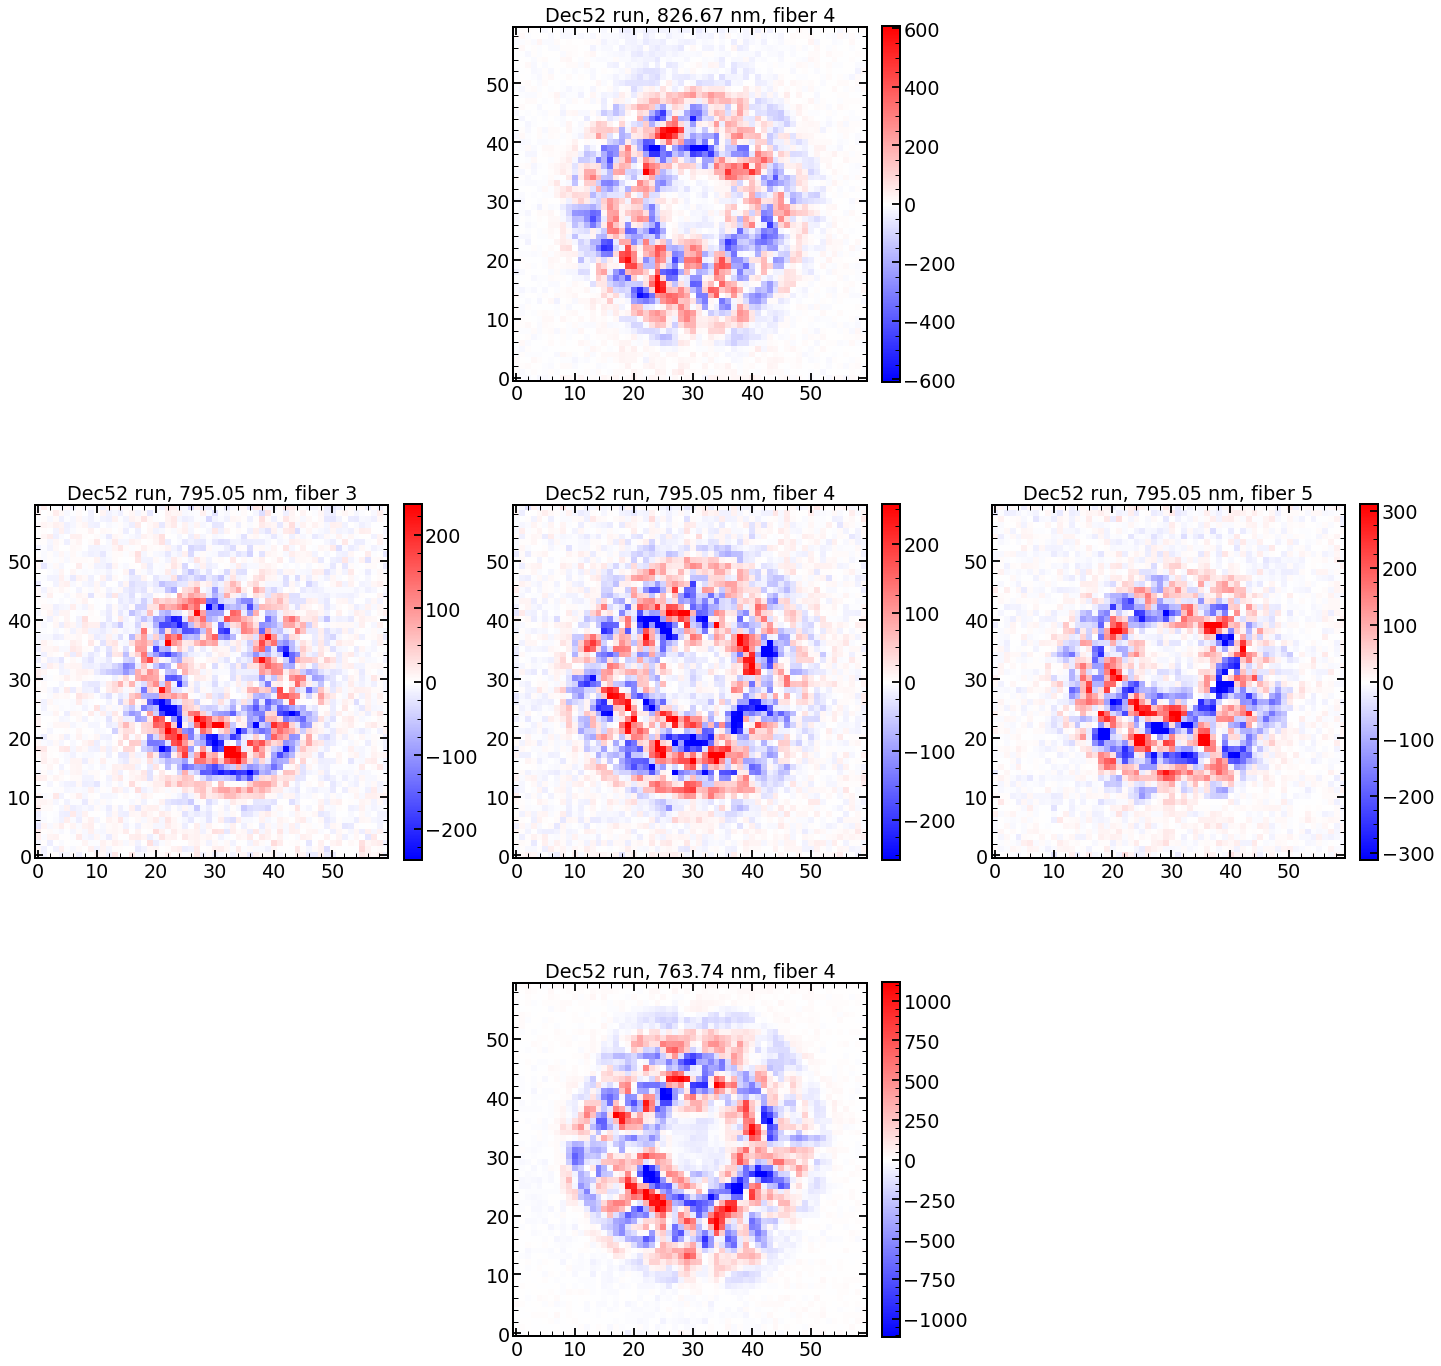

In [231]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))
#plt.suptitle('Residuals - Dec52 run, direct fit to defocused data, scale=5% of max value in the data')

plt.subplot(332)
plt.imshow(test_image_top-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('Dec52 run, 826.67 nm, fiber 4')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(338)
plt.title('Dec52 run, 763.74 nm, fiber 4')
plt.imshow(test_image_bottom-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(334)
plt.title('Dec52 run, 795.05 nm, fiber 3')
plt.imshow(test_image_left-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(336)
plt.title('Dec52 run, 795.05 nm, fiber 5')
plt.imshow(test_image_right-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(335)
plt.title('Dec52 run, 795.05 nm, fiber 4')
plt.imshow(test_image_center-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.subplots_adjust(top=0.1)
plt.tight_layout(pad=0.4 ,w_pad=0.5, h_pad=0.4)

In [232]:
single_number=78
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_right_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_right_int)
test_image_right_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_right_Dec23_int-sci_image_right)**2/var_image_right))


single_number=54
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_left_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_left_int)
test_image_left_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_left_Dec23_int-sci_image_left)**2/var_image_left))

single_number=65
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_bottom_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_bottom_int)
test_image_bottom_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_bottom_Dec23_int-sci_image_bottom)**2/var_image_bottom))

single_number=67
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_top_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_top_int)
test_image_top_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_top_Dec23_int-sci_image_top)**2/var_image_top))

single_number=66
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_center_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_center_int)
test_image_center_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_center_Dec23_int-sci_image_center)**2/var_image_center))

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5563.241942122578
minimal chi2 reduced is: 3.086052267381832
zmax: 22
4.067778512471553
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 4002.717957310271
minimal chi2 reduced is: 2.2191752034559378
zmax: 22
2.986654065988138
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 16820.23789200763
minimal chi2 reduced is: 9.339582285822212
zmax: 22
15.338599268245256
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 8193.431443158826
minimal chi2 reduced is: 4.547078653405777
zmax: 22
7.900396176401787
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5229.575249580849
minimal chi2 reduced is: 2.9006870130170097
zmax: 22
3.933188708146811


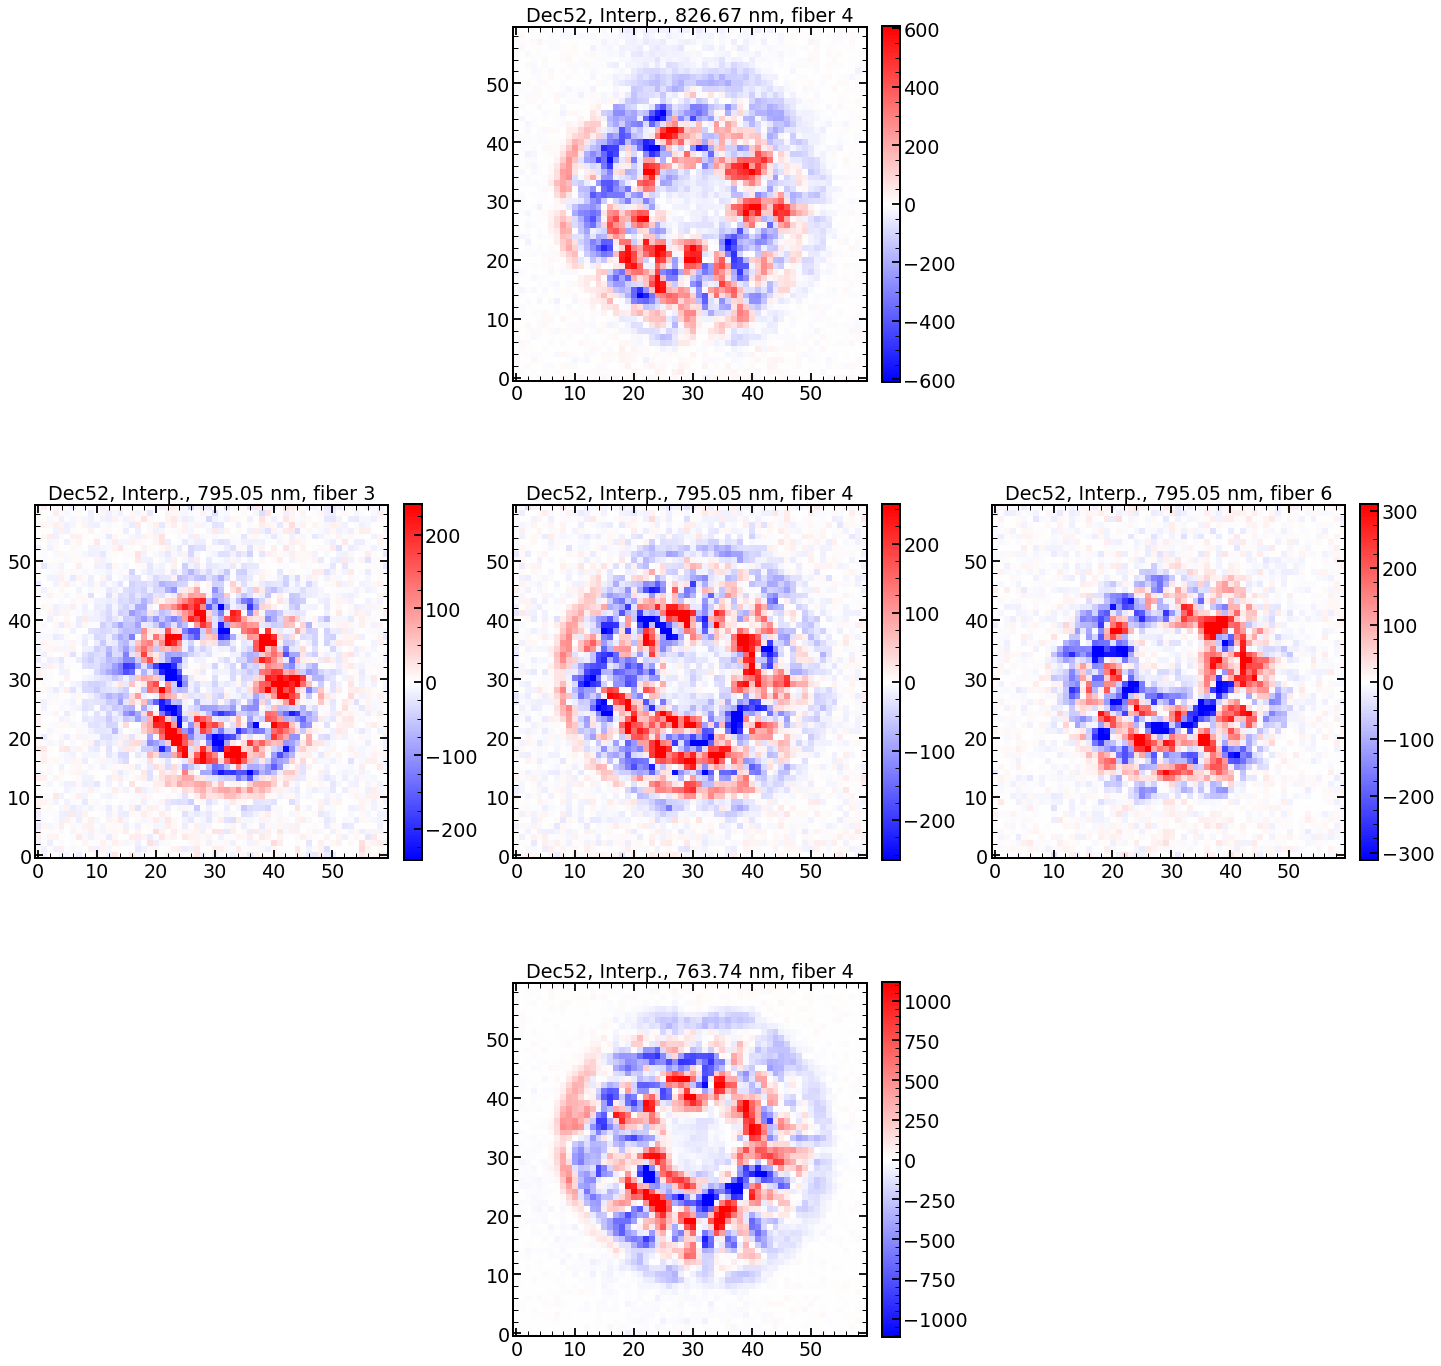

In [233]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))

plt.subplot(332)
plt.imshow(test_image_top_Dec23_int-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('Dec52, Interp., 826.67 nm, fiber 4')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(338)
plt.title('Dec52, Interp., 763.74 nm, fiber 4')
plt.imshow(test_image_bottom_Dec23_int-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(334)
plt.title('Dec52, Interp., 795.05 nm, fiber 3')
plt.imshow(test_image_left_Dec23_int-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(336)
plt.title('Dec52, Interp., 795.05 nm, fiber 6')
plt.imshow(test_image_right_Dec23_int-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(335)
plt.title('Dec52, Interp., 795.05 nm, fiber 4')
plt.imshow(test_image_center_Dec23_int-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout(pad=0.4 ,w_pad=0.5, h_pad=0.4)

## Focus

In [237]:
len(list_of_Ne_to_analyze)

24

In [239]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(53)+'S'+str(single_spot)+'DecHgAr.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8603,8597,8594,8591,8588,8585,8582,8579,8576]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI53_focus.py "+str(obs)+" "+str(single_spot)+" 30 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger53HgAr'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(53)+'S'+str(single_spot)+'DecHgAr.sh \n')

file.close()

#MPI
for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(53)+'S'+str(single_spot)+'DecNe.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 12:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in np.array([8603,8597,8594,8591,8588,8585,8582,8579,8576])+90:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI53_focus.py "+str(obs)+" "+str(single_spot)+" 30 5 Ne\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger53Ne'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(53)+'S'+str(single_spot)+'DecNe.sh \n')

file.close()